# Capturing long-term dependencies with LSTMs

In this notebook we will test different configurations of RNNs and see how they perform.

Outline:
1. [Short-distance dataset with 10 periods: Linear model versus Simple RNN](#Section-1.-Short-distance-dataset-with-10-periods:-Linear-model-versus-Simple-RNN)
1. [Long-distance dataset with 10 periods: Simple RNN versus LSTM](#Section-2.-Long-distance-dataset-with-10-periods:-Simple-RNN-versus-LSTM)
1. [Long-distance dataset with 20 periods: Simple RNN versus LSTM versus GRU](#Section-3.-Long-distance-dataset-with-20-periods:-Simple-RNN-versus-LSTM-versus-GRU)
1. [Hitting the limit of the LSTM: use Global Max Pooling](#Section-4.-Hitting-the-limit-of-the-LSTM:-use-Global-Max-Pooling)

In [1]:
%matplotlib notebook
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils

In [2]:
tf.__version__

'2.3.1'

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Section 1. Short-distance dataset with 10 periods: Linear model versus Simple RNN

Just for the sake of replication, I imported my own datasets. However, we should be able to generate them making use of the `utils.generate_distance()` function.

Rows are samples and columns time steps. Thus, a row is a sequence of random values coming from a normal standard distribution for 10 time steps.

In [15]:
data_short10 = pd.read_csv('data/xor10_short.csv', index_col=0)
data_short10

0         1         2         3         4         5         6  \
0    -0.347167  0.180646  0.479704 -0.379384  0.591553  0.491876  2.425621   
1    -0.811868  0.368232 -0.820585 -0.763253  1.087861  0.261214 -0.938820   
2    -0.871913 -1.144904  0.590068  0.163802 -0.295389 -0.201298 -0.708277   
3    -0.690922 -1.730924 -0.054536  0.651995 -0.545174 -1.784856 -0.129548   
4    -1.615000 -0.335704 -1.257434  1.094222 -0.589852 -0.770867  0.009162   
...        ...       ...       ...       ...       ...       ...       ...   
4995 -0.082797  2.417874 -0.355266 -0.850585  0.540557  1.244503  0.509711   
4996 -0.774517 -0.909877  0.562672 -0.218940  0.018033  0.409960 -0.941905   
4997 -1.664744 -1.152928  0.687370 -0.447970  0.243767 -0.095498 -2.392940   
4998  0.181828 -0.819450  0.293142 -0.485337  0.272713  0.370028 -2.420577   
4999 -0.323583  0.293247 -0.116331 -0.625016  0.351134  1.119566  0.488472   

             7         8         9  Y  
0    -0.472849  1.176760 -0.891470  0  
1    -1.156446 -0.547493  1.477342  0  
2     0.622546  1.283568  1.149649  0  
3     0.876852  1.044099 -0.822859  1  
4     0.929367  0.115576  1.845343  0  
...        ...       ...       ... ..  
4995  0.133651 -0.396447 -0.020277  0  
4996 -0.503495 -1.222098  1.993182  0  
4997 -0.496066 -0.497013 -1.311405  1  
4998 -0.454588  0.017395  0.434477  1  
4999 -1.052969 -0.028559 -0.268712  1  

[5000 rows x 11 columns]

In [47]:
X = data_short10.drop('Y', axis=1).to_numpy()
Y = data_short10['Y'].to_numpy()

N, T = X.shape
D: int = 1

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 10), Y.shape: (5000,)


In [19]:
cases: tuple = ('short-distance-10', 'long-distance-10', 'long-distance-20', 'long-distance-30')

results: dict = {case: {} for case in cases}

### Linear model

In [34]:
inputs = Input(shape=(T,))
x = Dense(1, activation='sigmoid')(inputs)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [35]:
results['short-distance-10']['linreg'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

In [36]:
results['short-distance-10']['linreg'].history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<IPython.core.display.Javascript object>


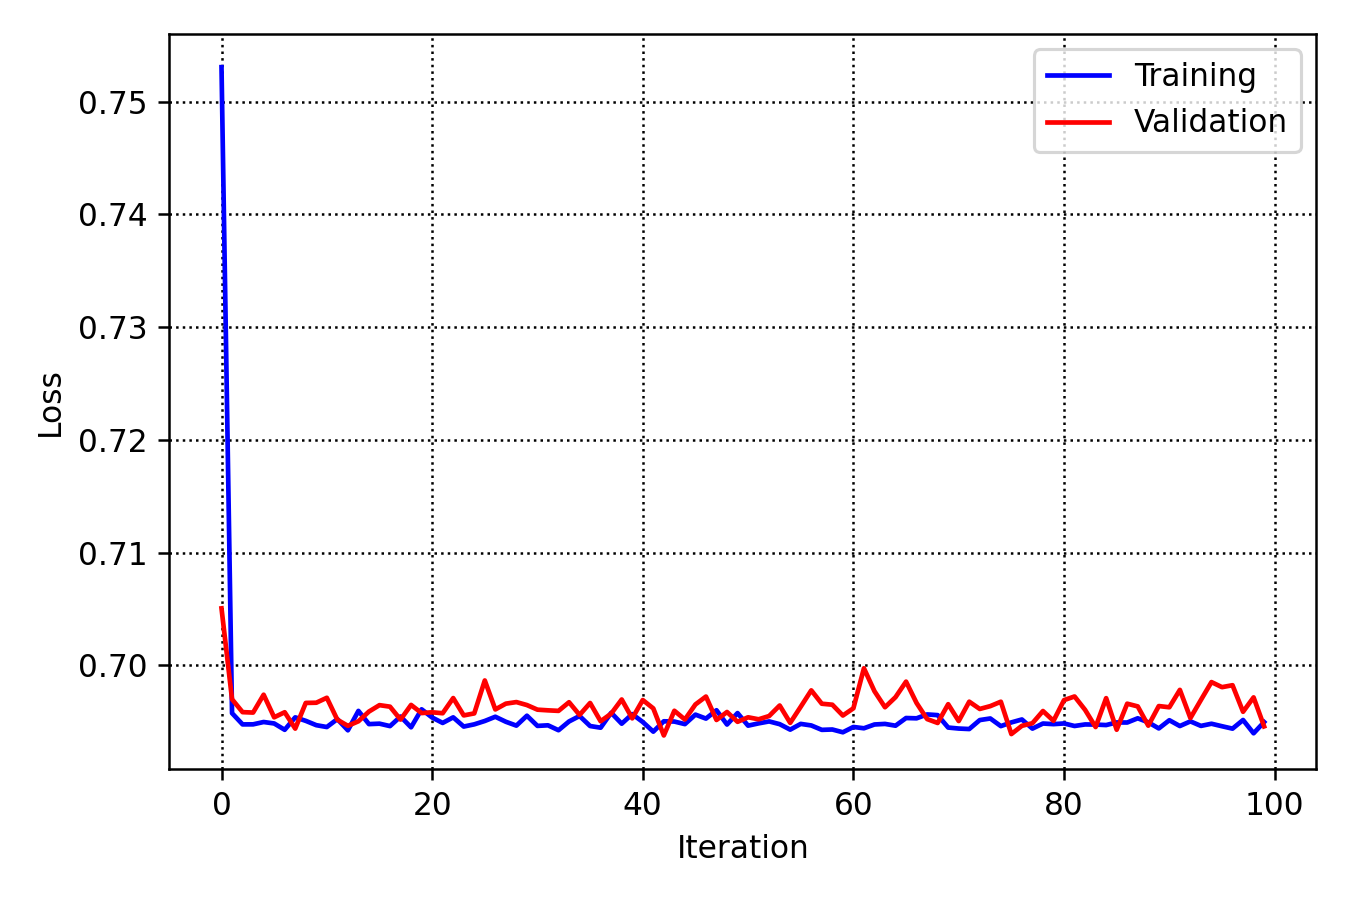

In [37]:
utils.plot_loss(results['short-distance-10']['linreg'].history['loss'], 
                results['short-distance-10']['linreg'].history['val_loss'],
                save=False, imgname='loss_st10_xor_linreg')

<IPython.core.display.Javascript object>


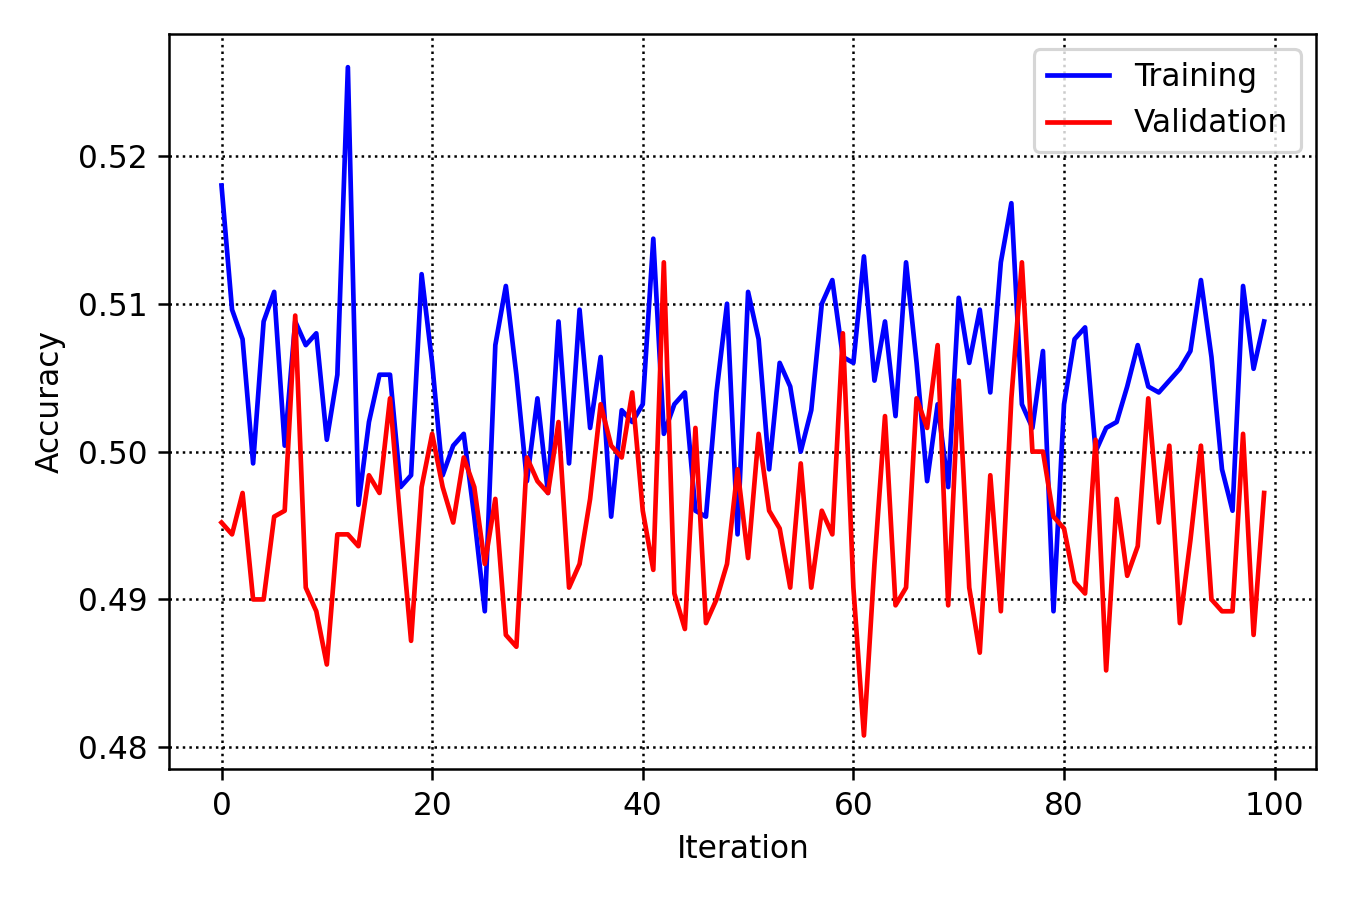

In [38]:
utils.plot_accuracy(results['short-distance-10']['linreg'].history['accuracy'], 
                    results['short-distance-10']['linreg'].history['val_accuracy'],
                    save=False, imgname='accuracy_st10_xor_linreg')

### Simple RNN

In [48]:
X_3D = np.expand_dims(X, -1)
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [50]:
results['short-distance-10']['simple-rnn'] = model.fit(X_3D, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


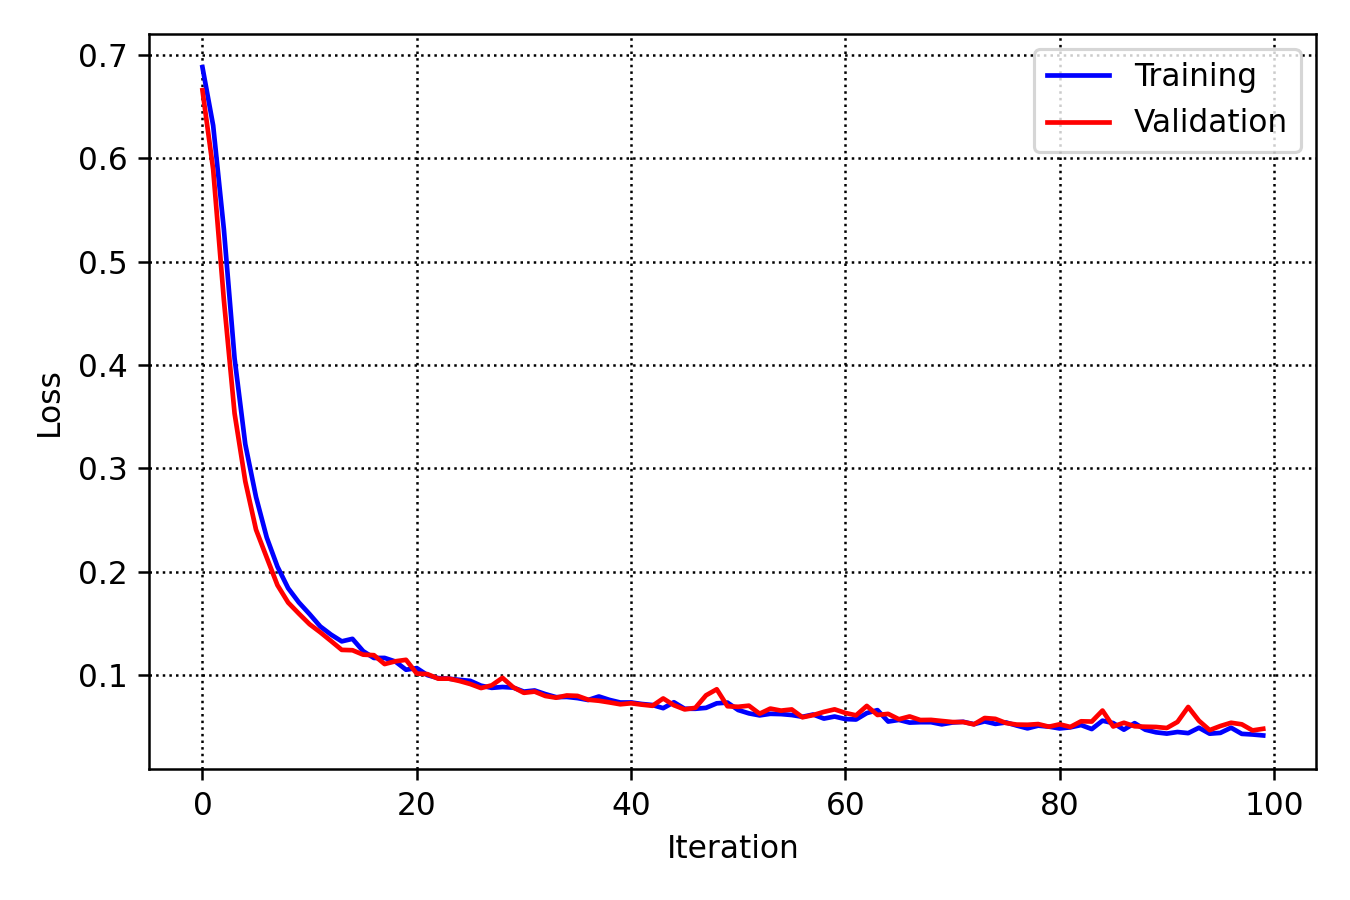

In [51]:
utils.plot_loss(results['short-distance-10']['simple-rnn'].history['loss'], 
                results['short-distance-10']['simple-rnn'].history['val_loss'],
                save=False, imgname='loss_st10_xor_rnn')

<IPython.core.display.Javascript object>


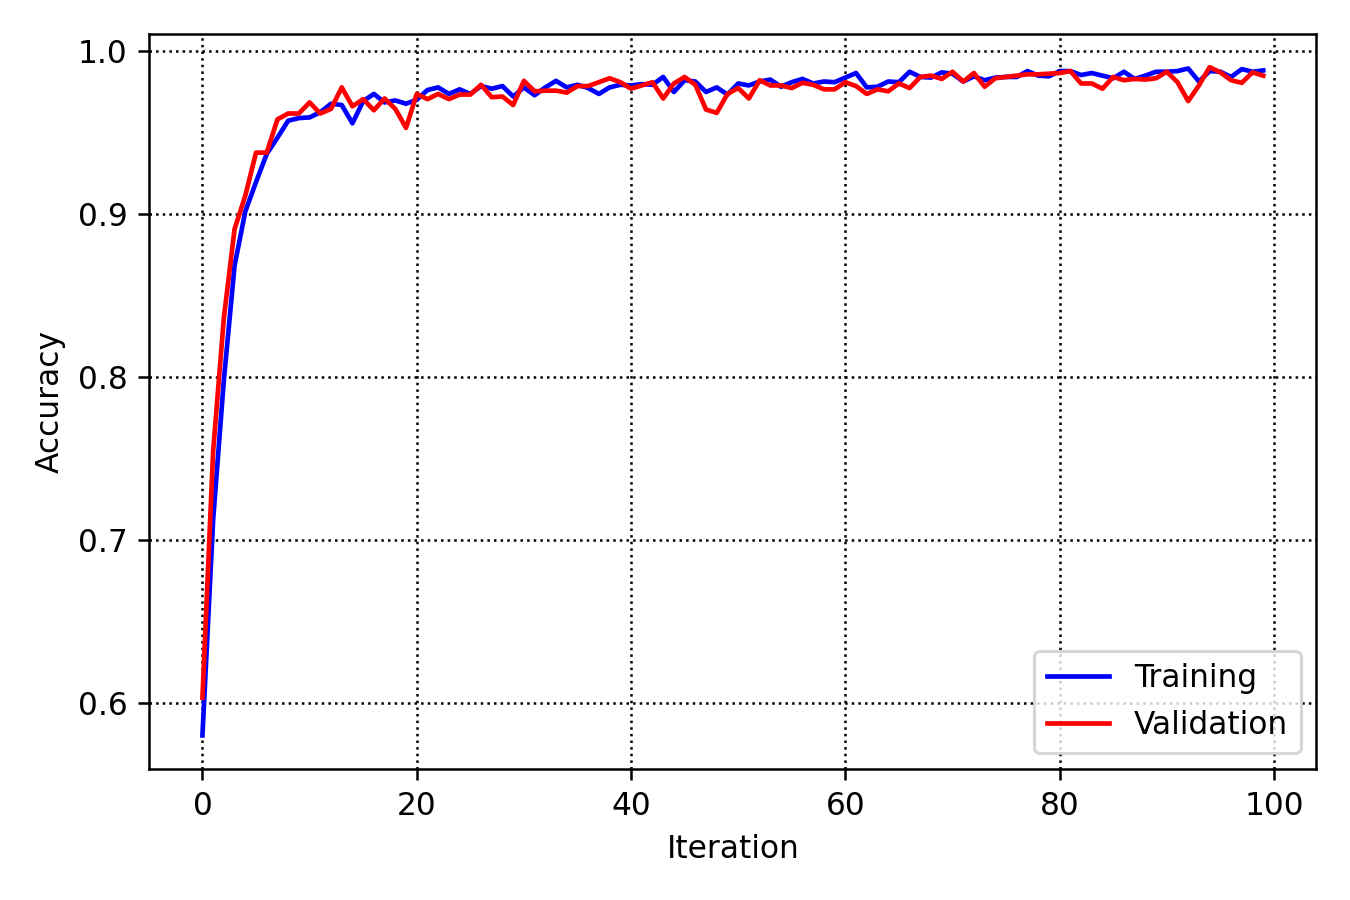

In [52]:
utils.plot_accuracy(results['short-distance-10']['simple-rnn'].history['accuracy'],
                    results['short-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_st10_xor_rnn')

The Simple RNN has low loss and a high accuracy curve. They look good, as expected. Meaning that a Simple RNN can solve this problem. Since the part if the time series that affects the classification result is a the end of the sequence, it does not require any long term memory. Thus, the vanishing gradient problem is not an issue here.

## Section 2. Long-distance dataset with 10 periods: Simple RNN versus LSTM

In [65]:
data_long10 = pd.read_csv('data/xor10_long.csv', index_col=0)
X = data_long10.drop('Y', axis=1).to_numpy()
Y = data_long10['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)  # Needed for RNN input

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 10, 1), Y.shape: (5000,)


In [60]:
inputs = Input(shape=(T, D))
x = SimpleRNN(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [61]:
results['long-distance-10']['simple-rnn'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


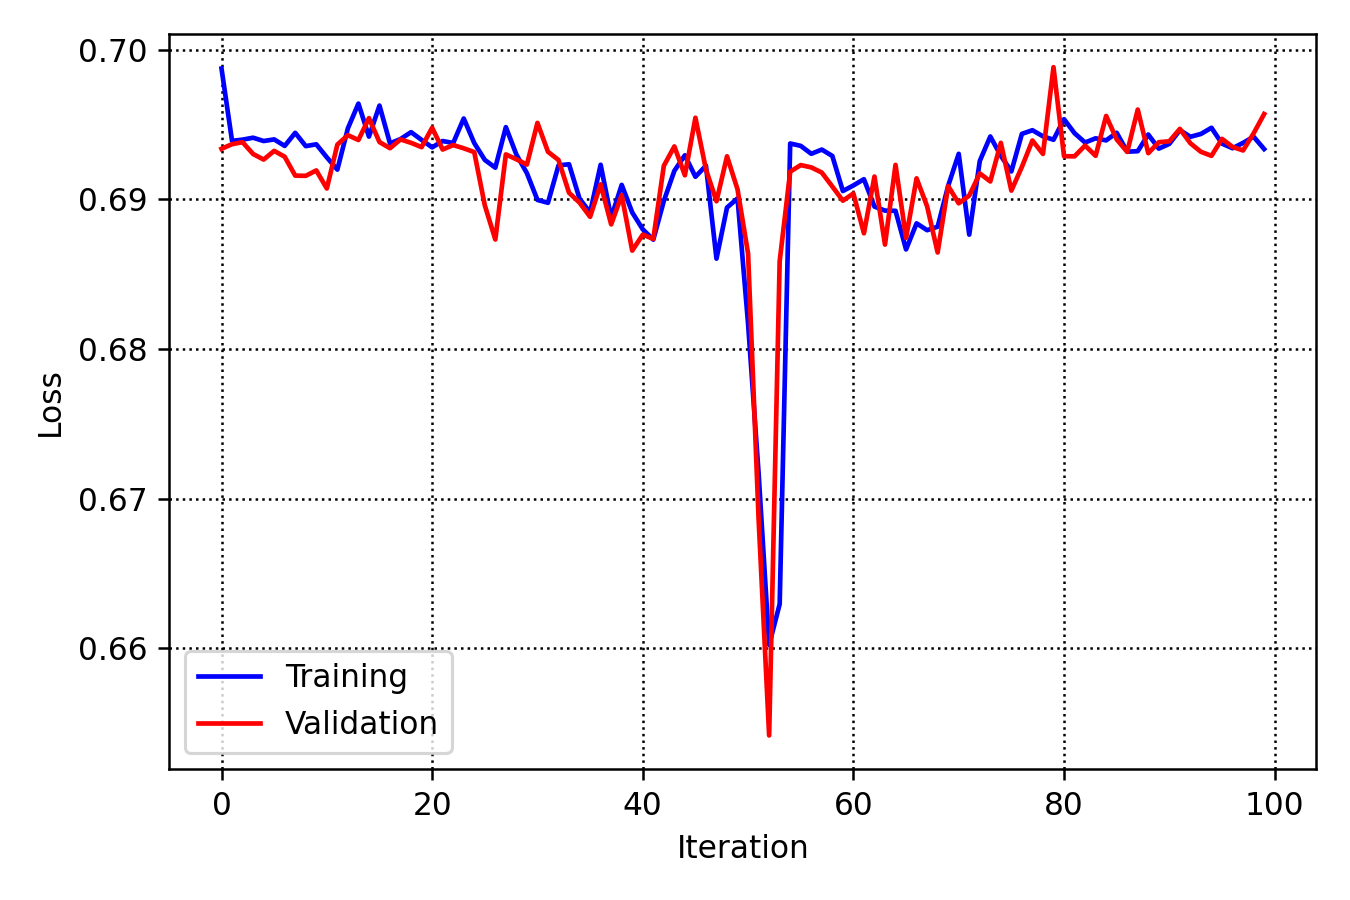

In [62]:
utils.plot_loss(results['long-distance-10']['simple-rnn'].history['loss'],
                results['long-distance-10']['simple-rnn'].history['val_loss'],
                save=False, imgname='loss_lt10_xor_rnn')

<IPython.core.display.Javascript object>


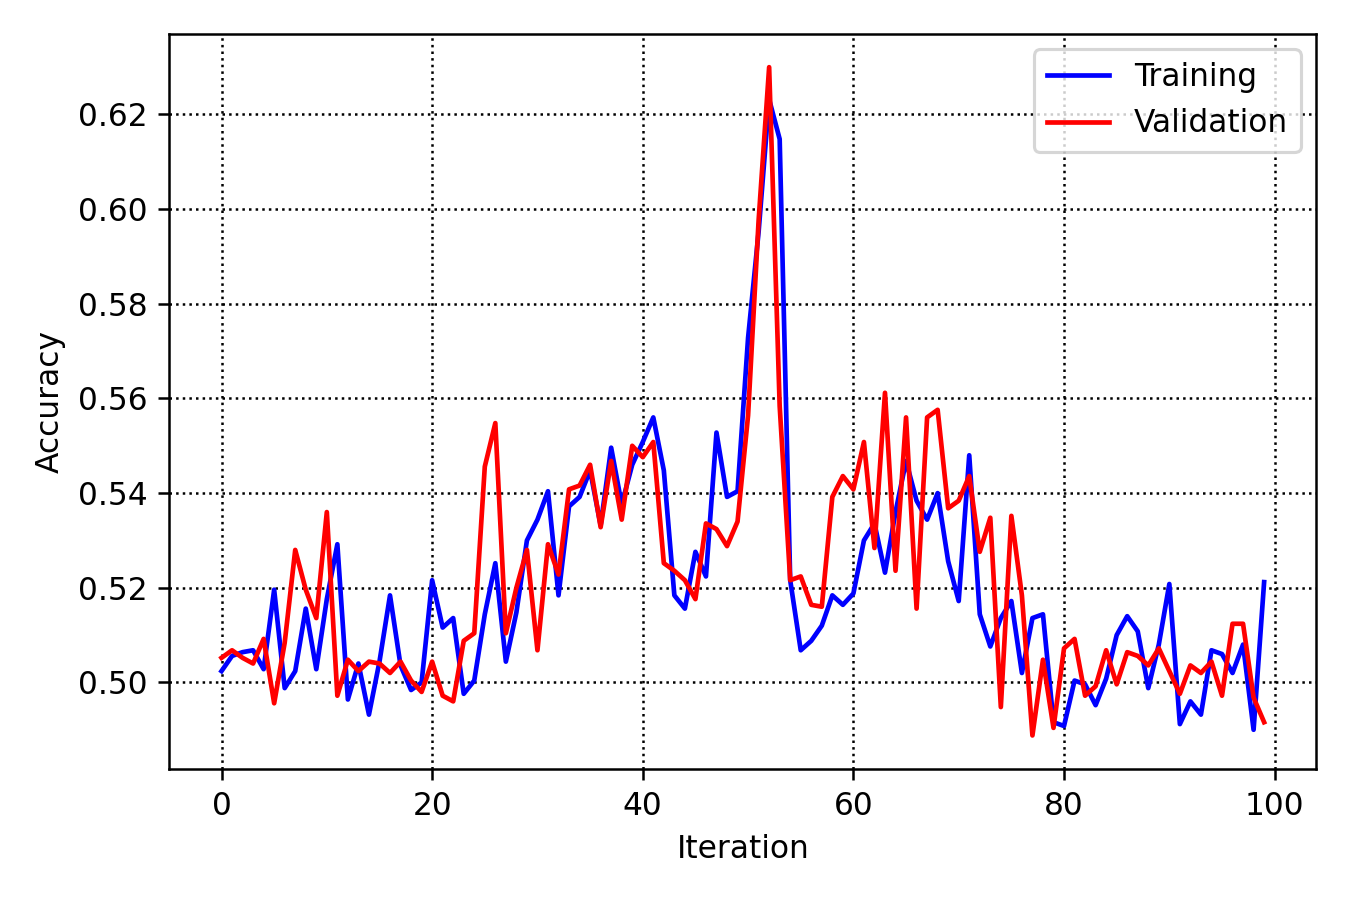

In [63]:
utils.plot_accuracy(results['long-distance-10']['simple-rnn'].history['accuracy'], 
                    results['long-distance-10']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_lt10_xor_rnn')

In [66]:
inputs = Input(shape=(T, D))
x = LSTM(5)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [67]:
results['long-distance-10']['lstm'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


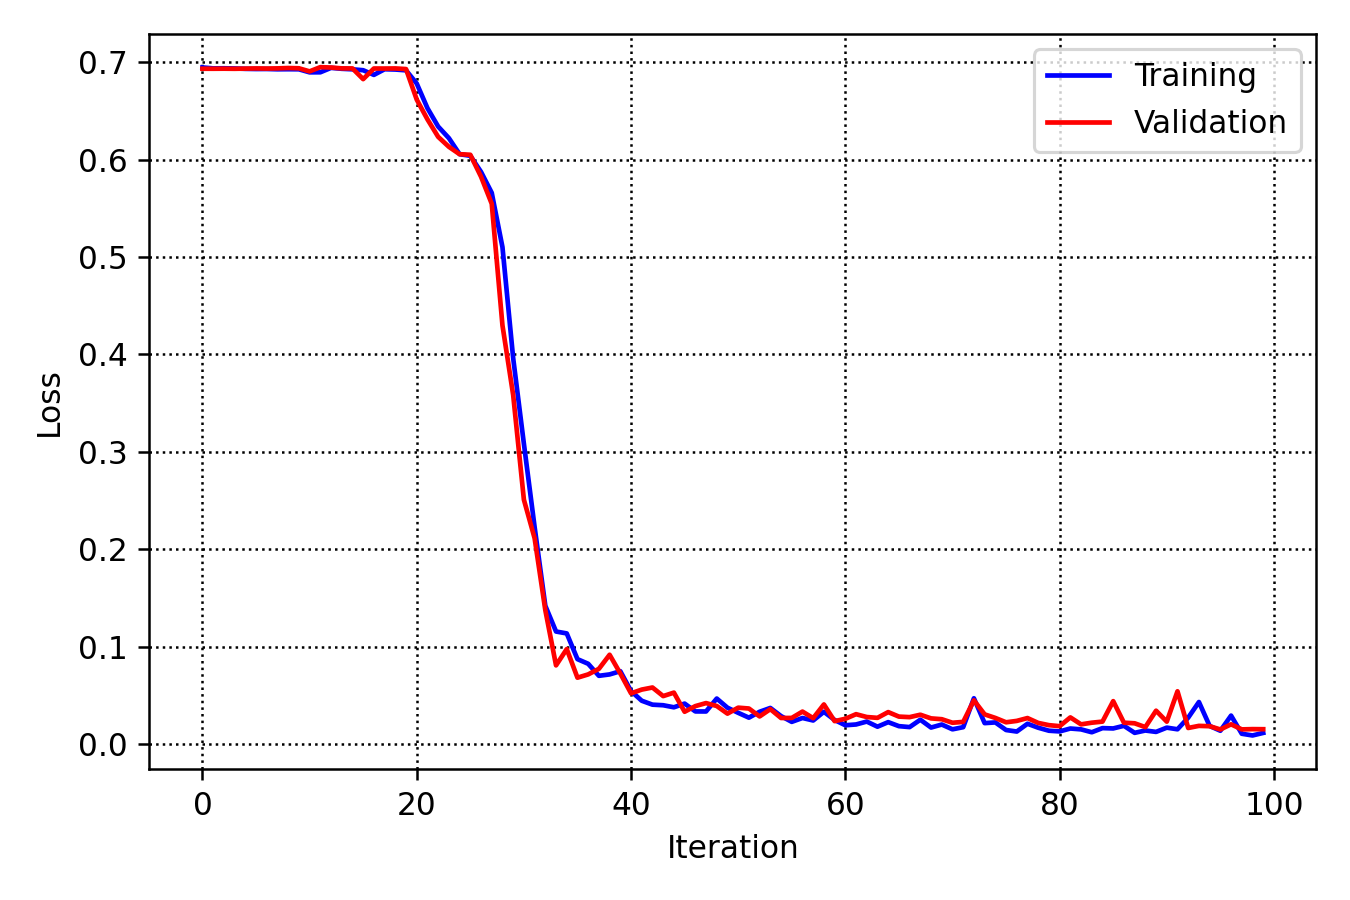

In [68]:
utils.plot_loss(results['long-distance-10']['lstm'].history['loss'],
                results['long-distance-10']['lstm'].history['val_loss'], 
                save=False, imgname='loss_lt10_xor_lstm')

<IPython.core.display.Javascript object>


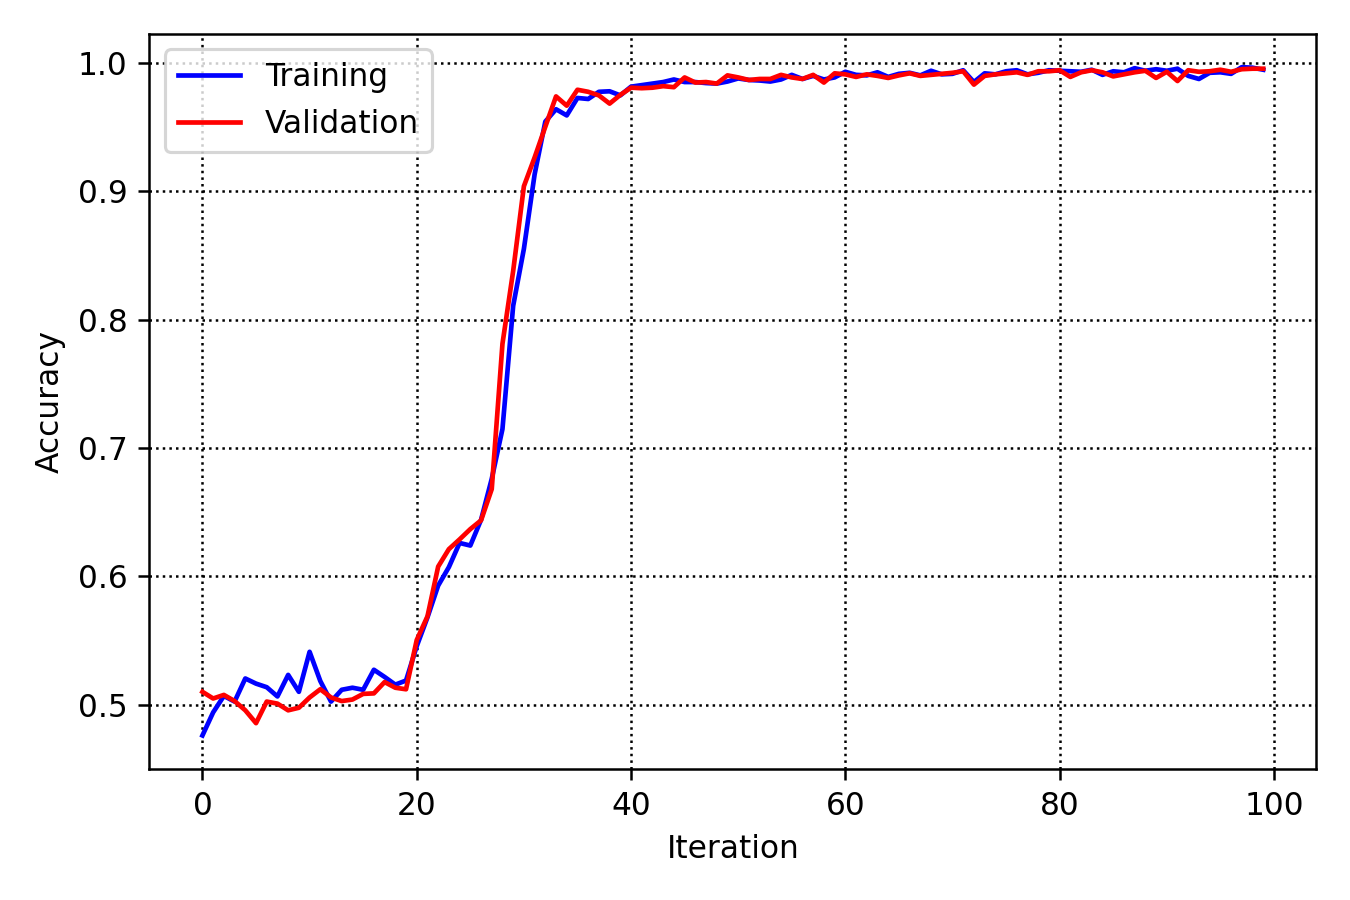

In [69]:
utils.plot_accuracy(results['long-distance-10']['lstm'].history['accuracy'],
                    results['long-distance-10']['lstm'].history['val_accuracy'], 
                    save=False, imgname='accuracy_lt10_xor_lstm')

## Section 3. Long-distance dataset with 20 periods: Simple RNN versus LSTM versus GRU

### Simple RNN

In [88]:
data_long20 = pd.read_csv('data/xor20_long.csv', index_col=0)
X = data_long20.drop('Y', axis=1).to_numpy()
Y = data_long20['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)  # Needed for RNN input

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 20, 1), Y.shape: (5000,)


In [105]:
inputs = Input(shape=(T, D))
x = SimpleRNN(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [106]:
results['long-distance-20']['simple-rnn'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


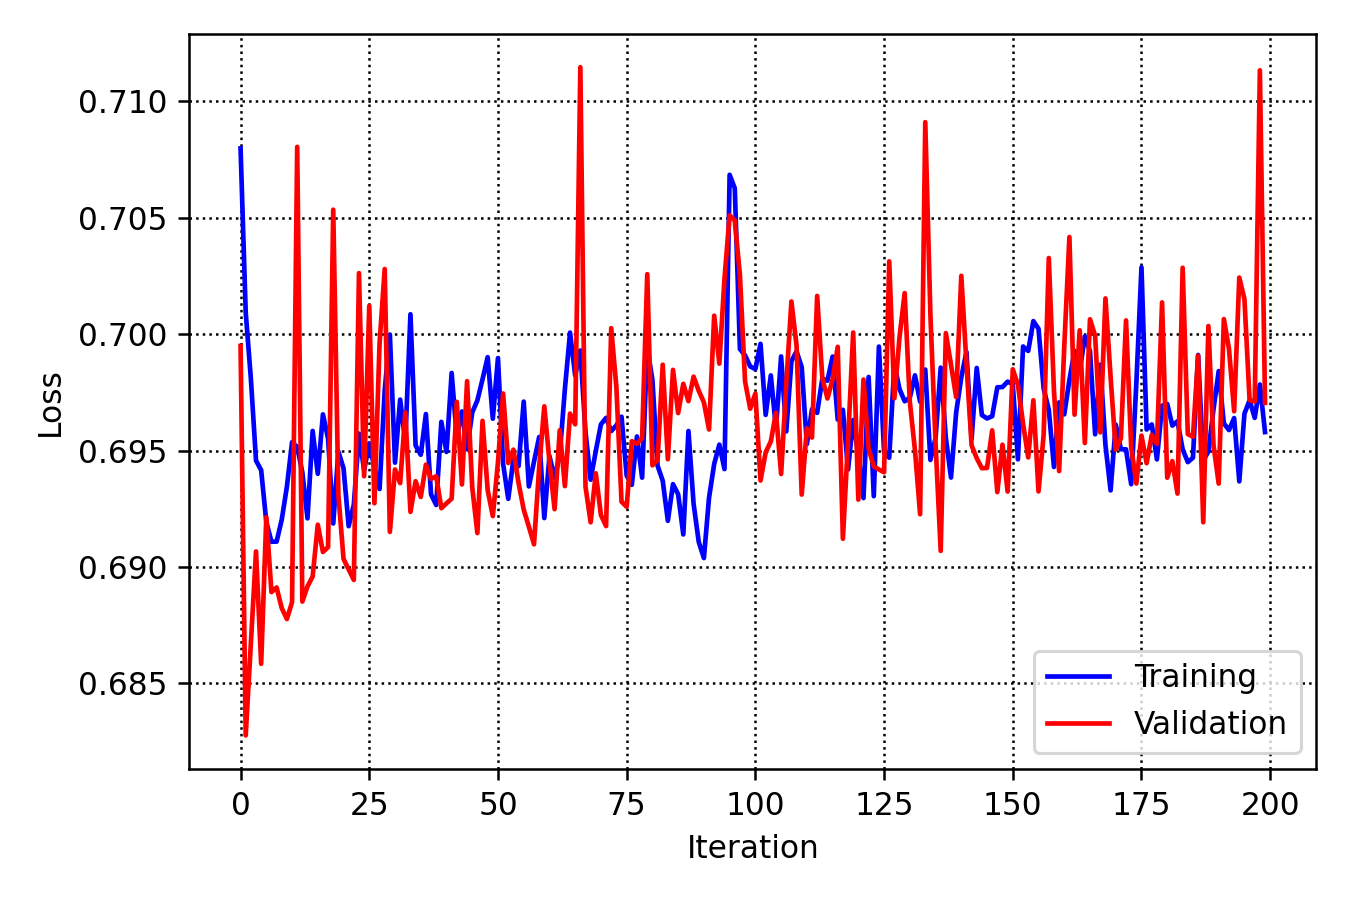

In [113]:
utils.plot_loss(results['long-distance-20']['simple-rnn'].history['loss'],
                results['long-distance-20']['simple-rnn'].history['val_loss'],
                save=True, imgname='loss_lt20_xor_rnn')

<IPython.core.display.Javascript object>


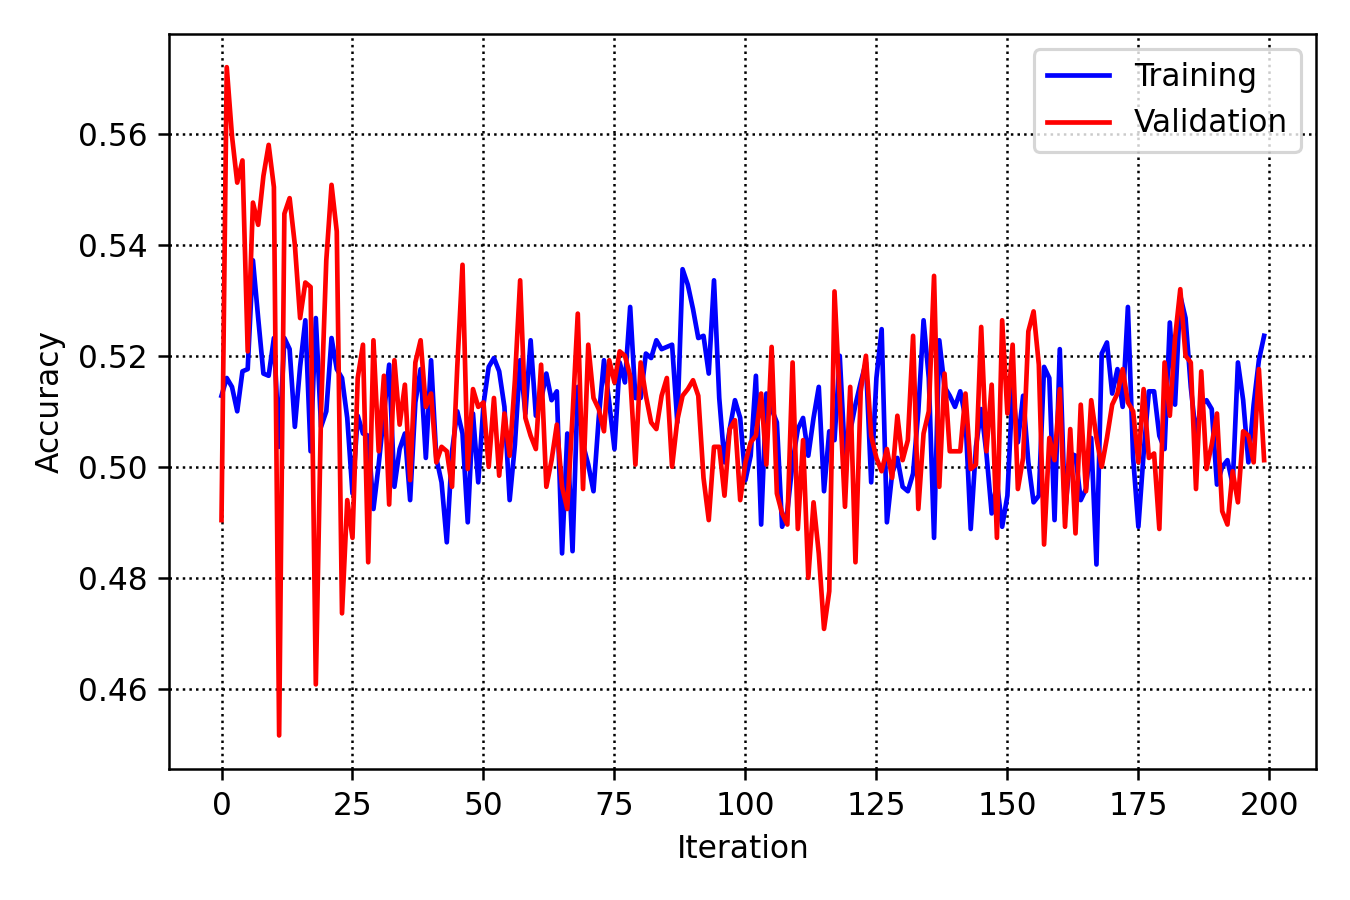

In [114]:
utils.plot_accuracy(results['long-distance-20']['simple-rnn'].history['accuracy'],
                    results['long-distance-20']['simple-rnn'].history['val_accuracy'],
                    save=False, imgname='accuracy_lt20_xor_rnn')

### LSTM

In [97]:
inputs = Input(shape=(T, D))
x = LSTM(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [98]:
results['long-distance-20']['lstm'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


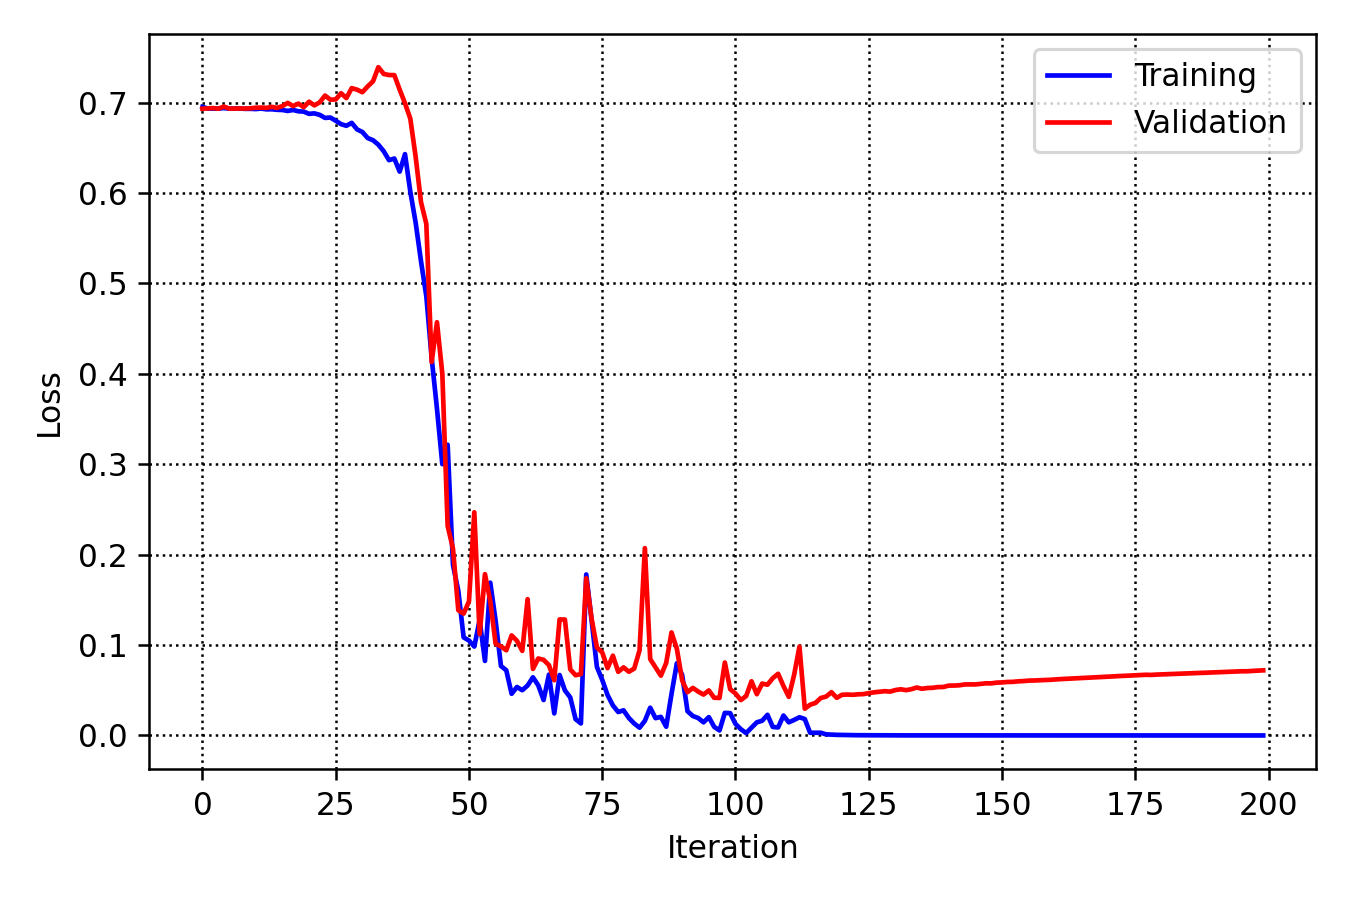

In [115]:
utils.plot_loss(results['long-distance-20']['lstm'].history['loss'],
                results['long-distance-20']['lstm'].history['val_loss'],
                save=True, imgname='loss_lt20_xor_lstm')

<IPython.core.display.Javascript object>


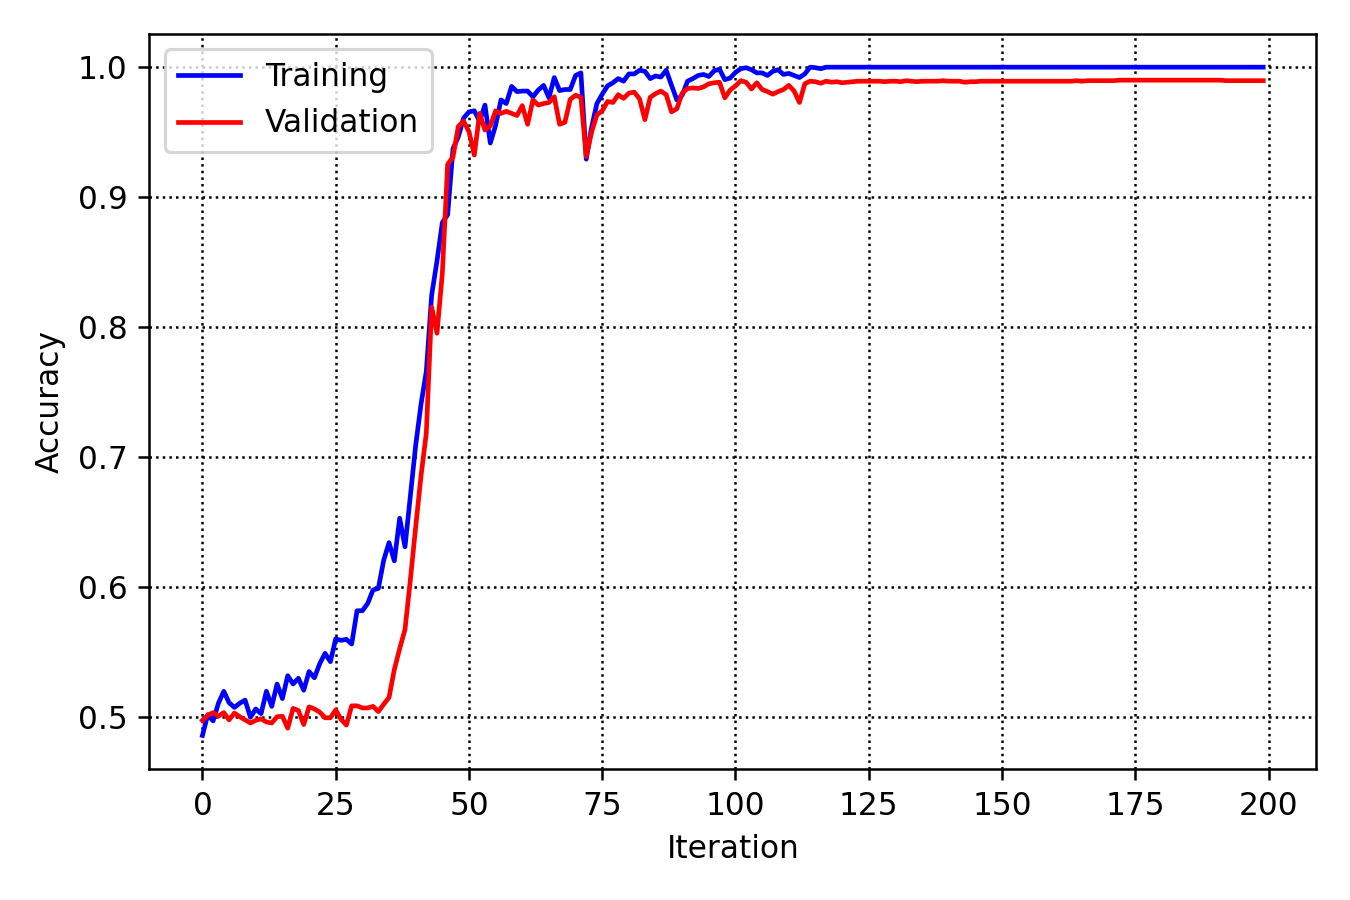

In [116]:
utils.plot_accuracy(results['long-distance-20']['lstm'].history['accuracy'],
                    results['long-distance-20']['lstm'].history['val_accuracy'], 
                    save=True, imgname='accuracy_lt20_xor_lstm')

### GRU

In [109]:
inputs = Input(shape=(T, D))
x = GRU(20)(inputs)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [110]:
results['long-distance-20']['gru'] = model.fit(X, Y, epochs=200, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


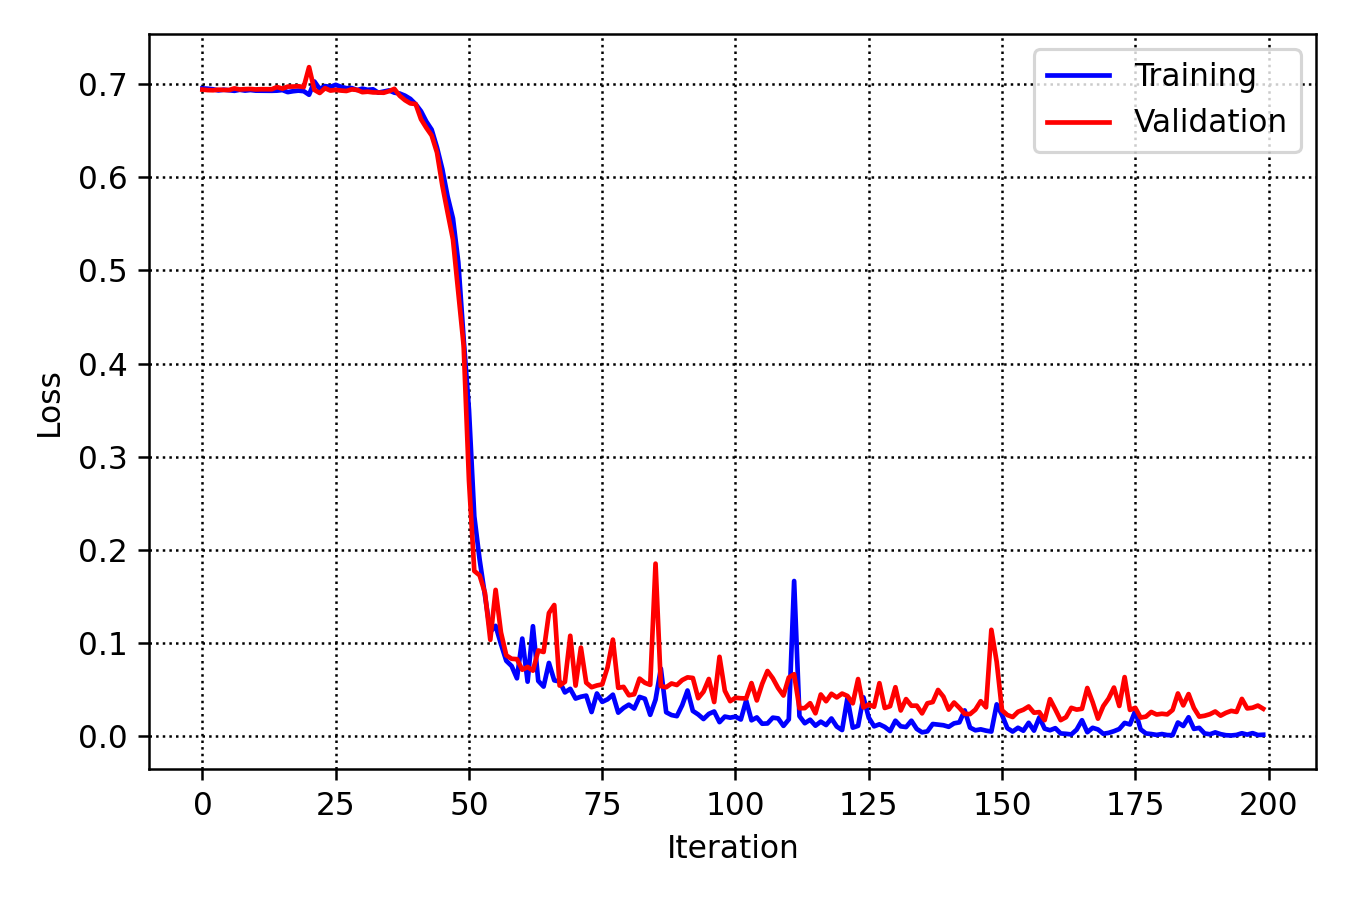

In [117]:
utils.plot_loss(results['long-distance-20']['gru'].history['loss'],
                results['long-distance-20']['gru'].history['val_loss'],
                save=True, imgname='loss_lt20_xor_gru')

<IPython.core.display.Javascript object>


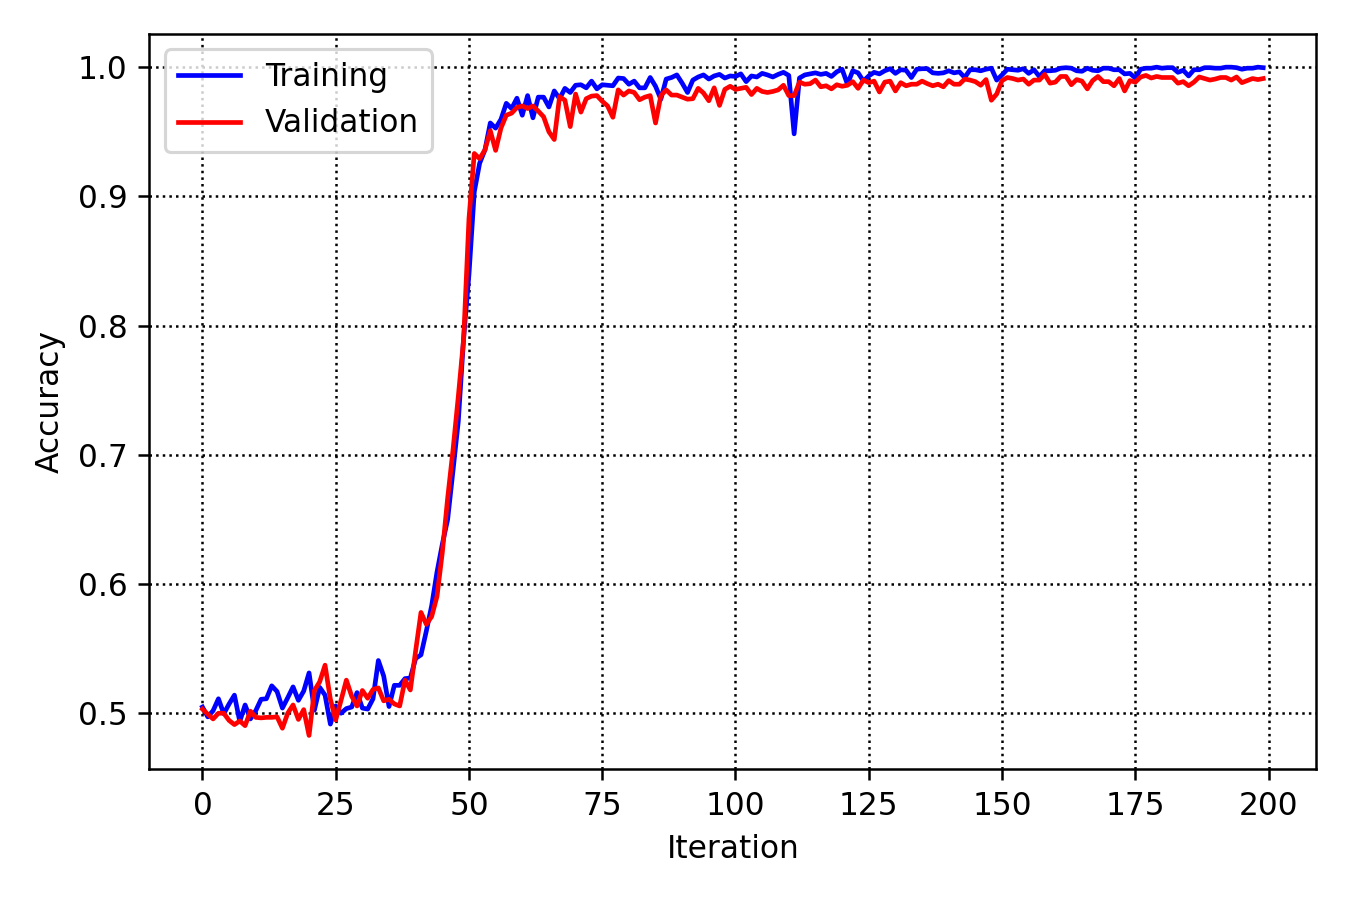

In [118]:
utils.plot_accuracy(results['long-distance-20']['gru'].history['accuracy'],
                    results['long-distance-20']['gru'].history['val_accuracy'], 
                    save=True, imgname='accuracy_lt20_xor_gru')

## Section 4. Hitting the limit of the LSTM: use Global Max Pooling

### LSTM

In [132]:
data_long30 = pd.read_csv('data/xor30_long.csv', index_col=0)
X = data_long30.drop('Y', axis=1).to_numpy()
Y = data_long30['Y'].to_numpy()

N, T = X.shape
D: int = 1
    
X = np.expand_dims(X, -1)

print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (5000, 30, 1), Y.shape: (5000,)


In [120]:
inputs = Input(shape=(T, D))

x = LSTM(20)(inputs)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [121]:
results['long-distance-30']['lstm'] = model.fit(X, Y, epochs=400, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


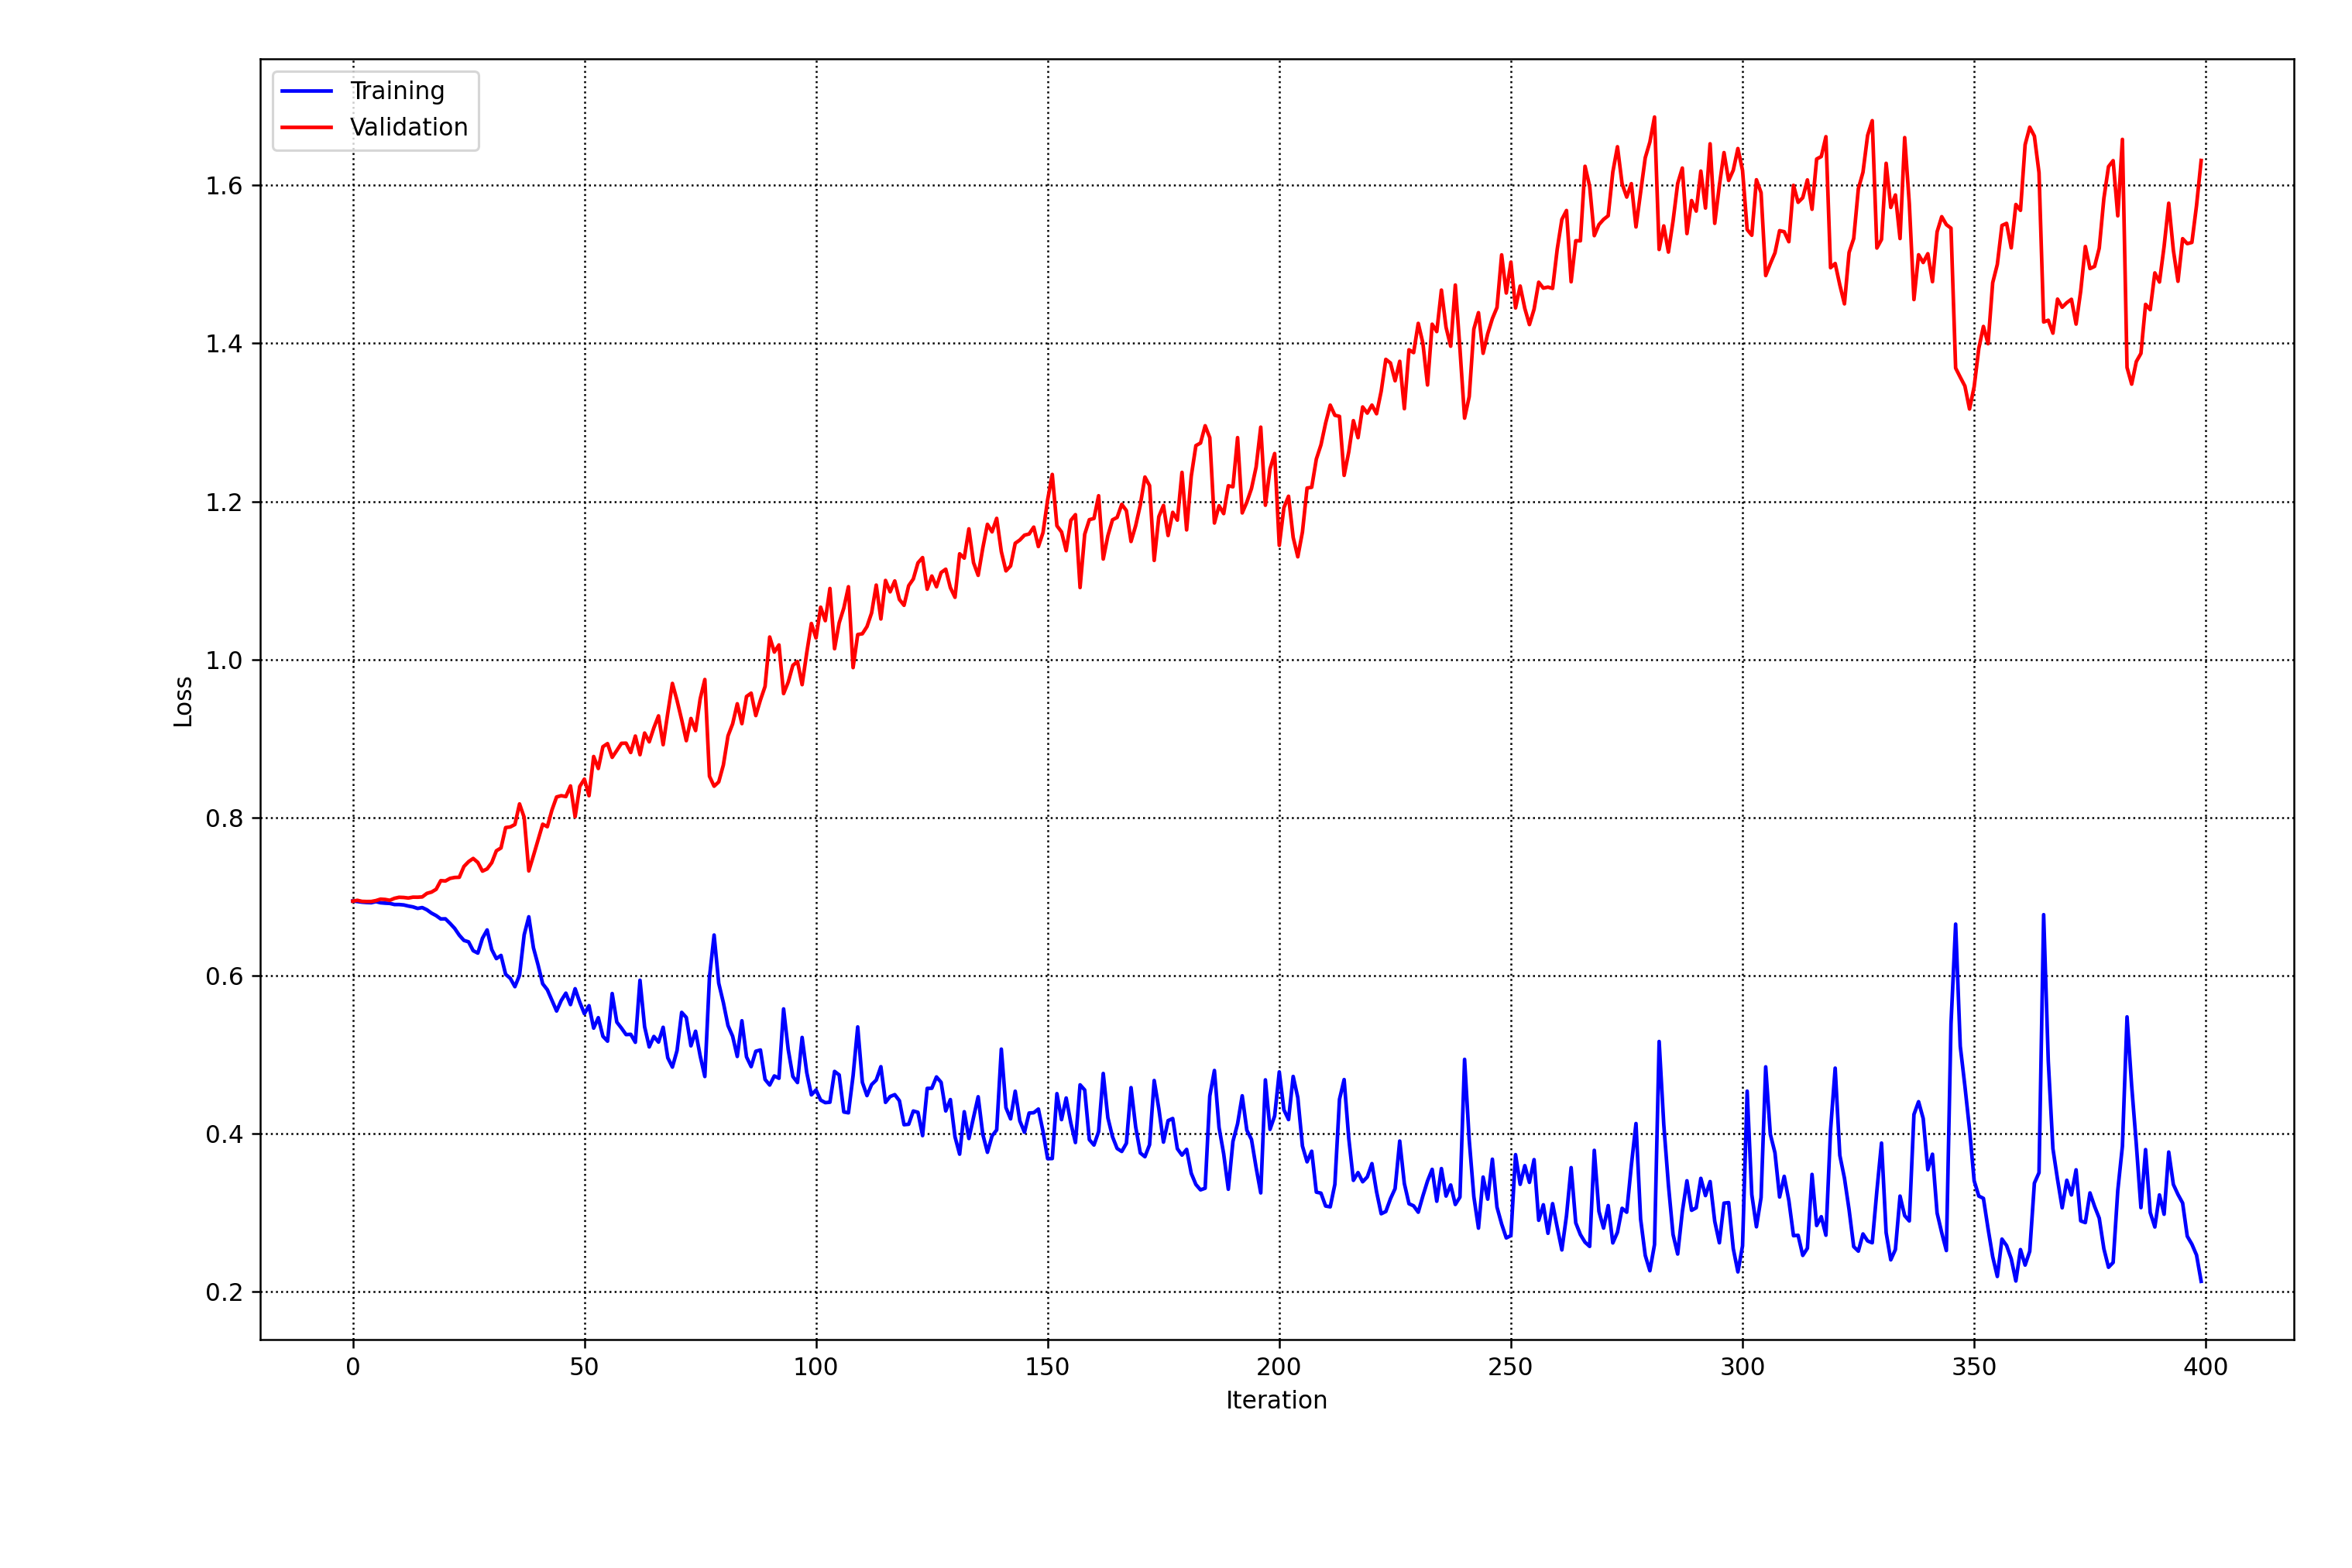

In [122]:
utils.plot_loss(results['long-distance-30']['lstm'].history['loss'],
                results['long-distance-30']['lstm'].history['val_loss'],
                save=True, imgname='loss_lt30_xor_lstm')

<IPython.core.display.Javascript object>


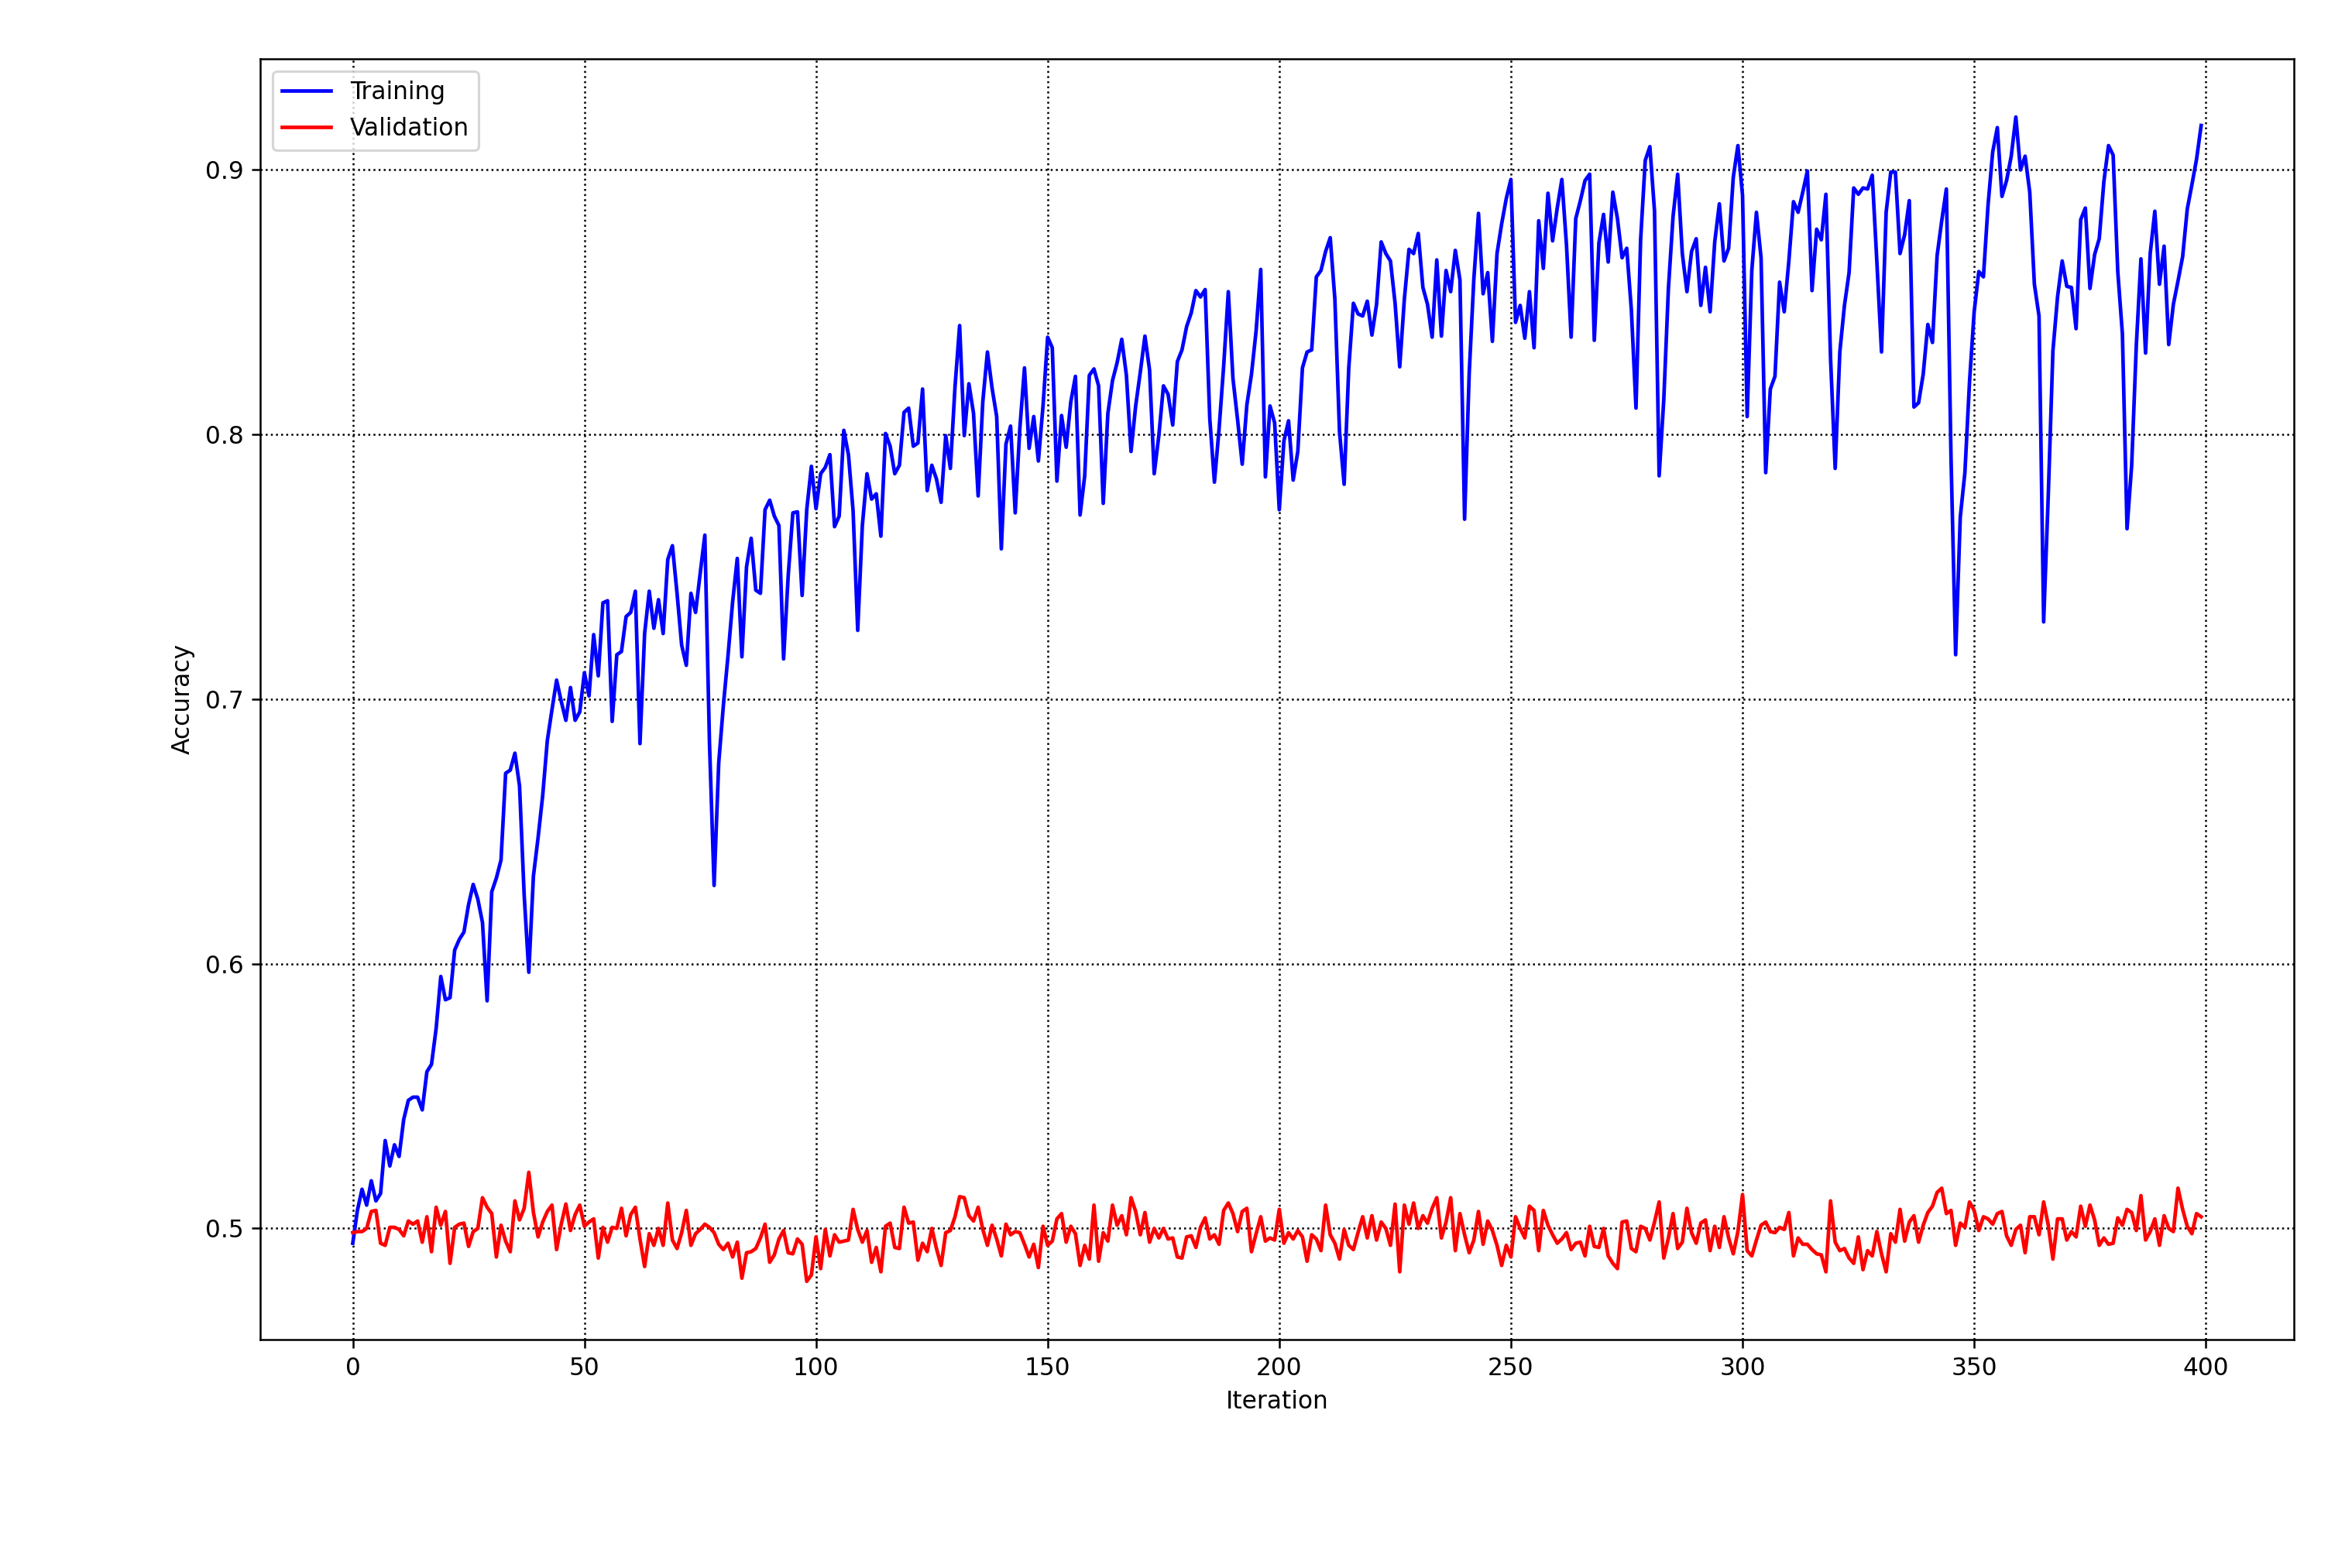

In [123]:
utils.plot_accuracy(results['long-distance-30']['lstm'].history['accuracy'],
                    results['long-distance-30']['lstm'].history['val_accuracy'], 
                    save=True, imgname='accuracy_lt30_xor_lstm')

### LSTM with GlobalMaxPooling1D

In [124]:
inputs = Input(shape=(T, D))

x = LSTM(20, return_sequences=True)(inputs)
x = GlobalMaxPool1D()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [125]:
results['long-distance-30']['lstm-pool'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


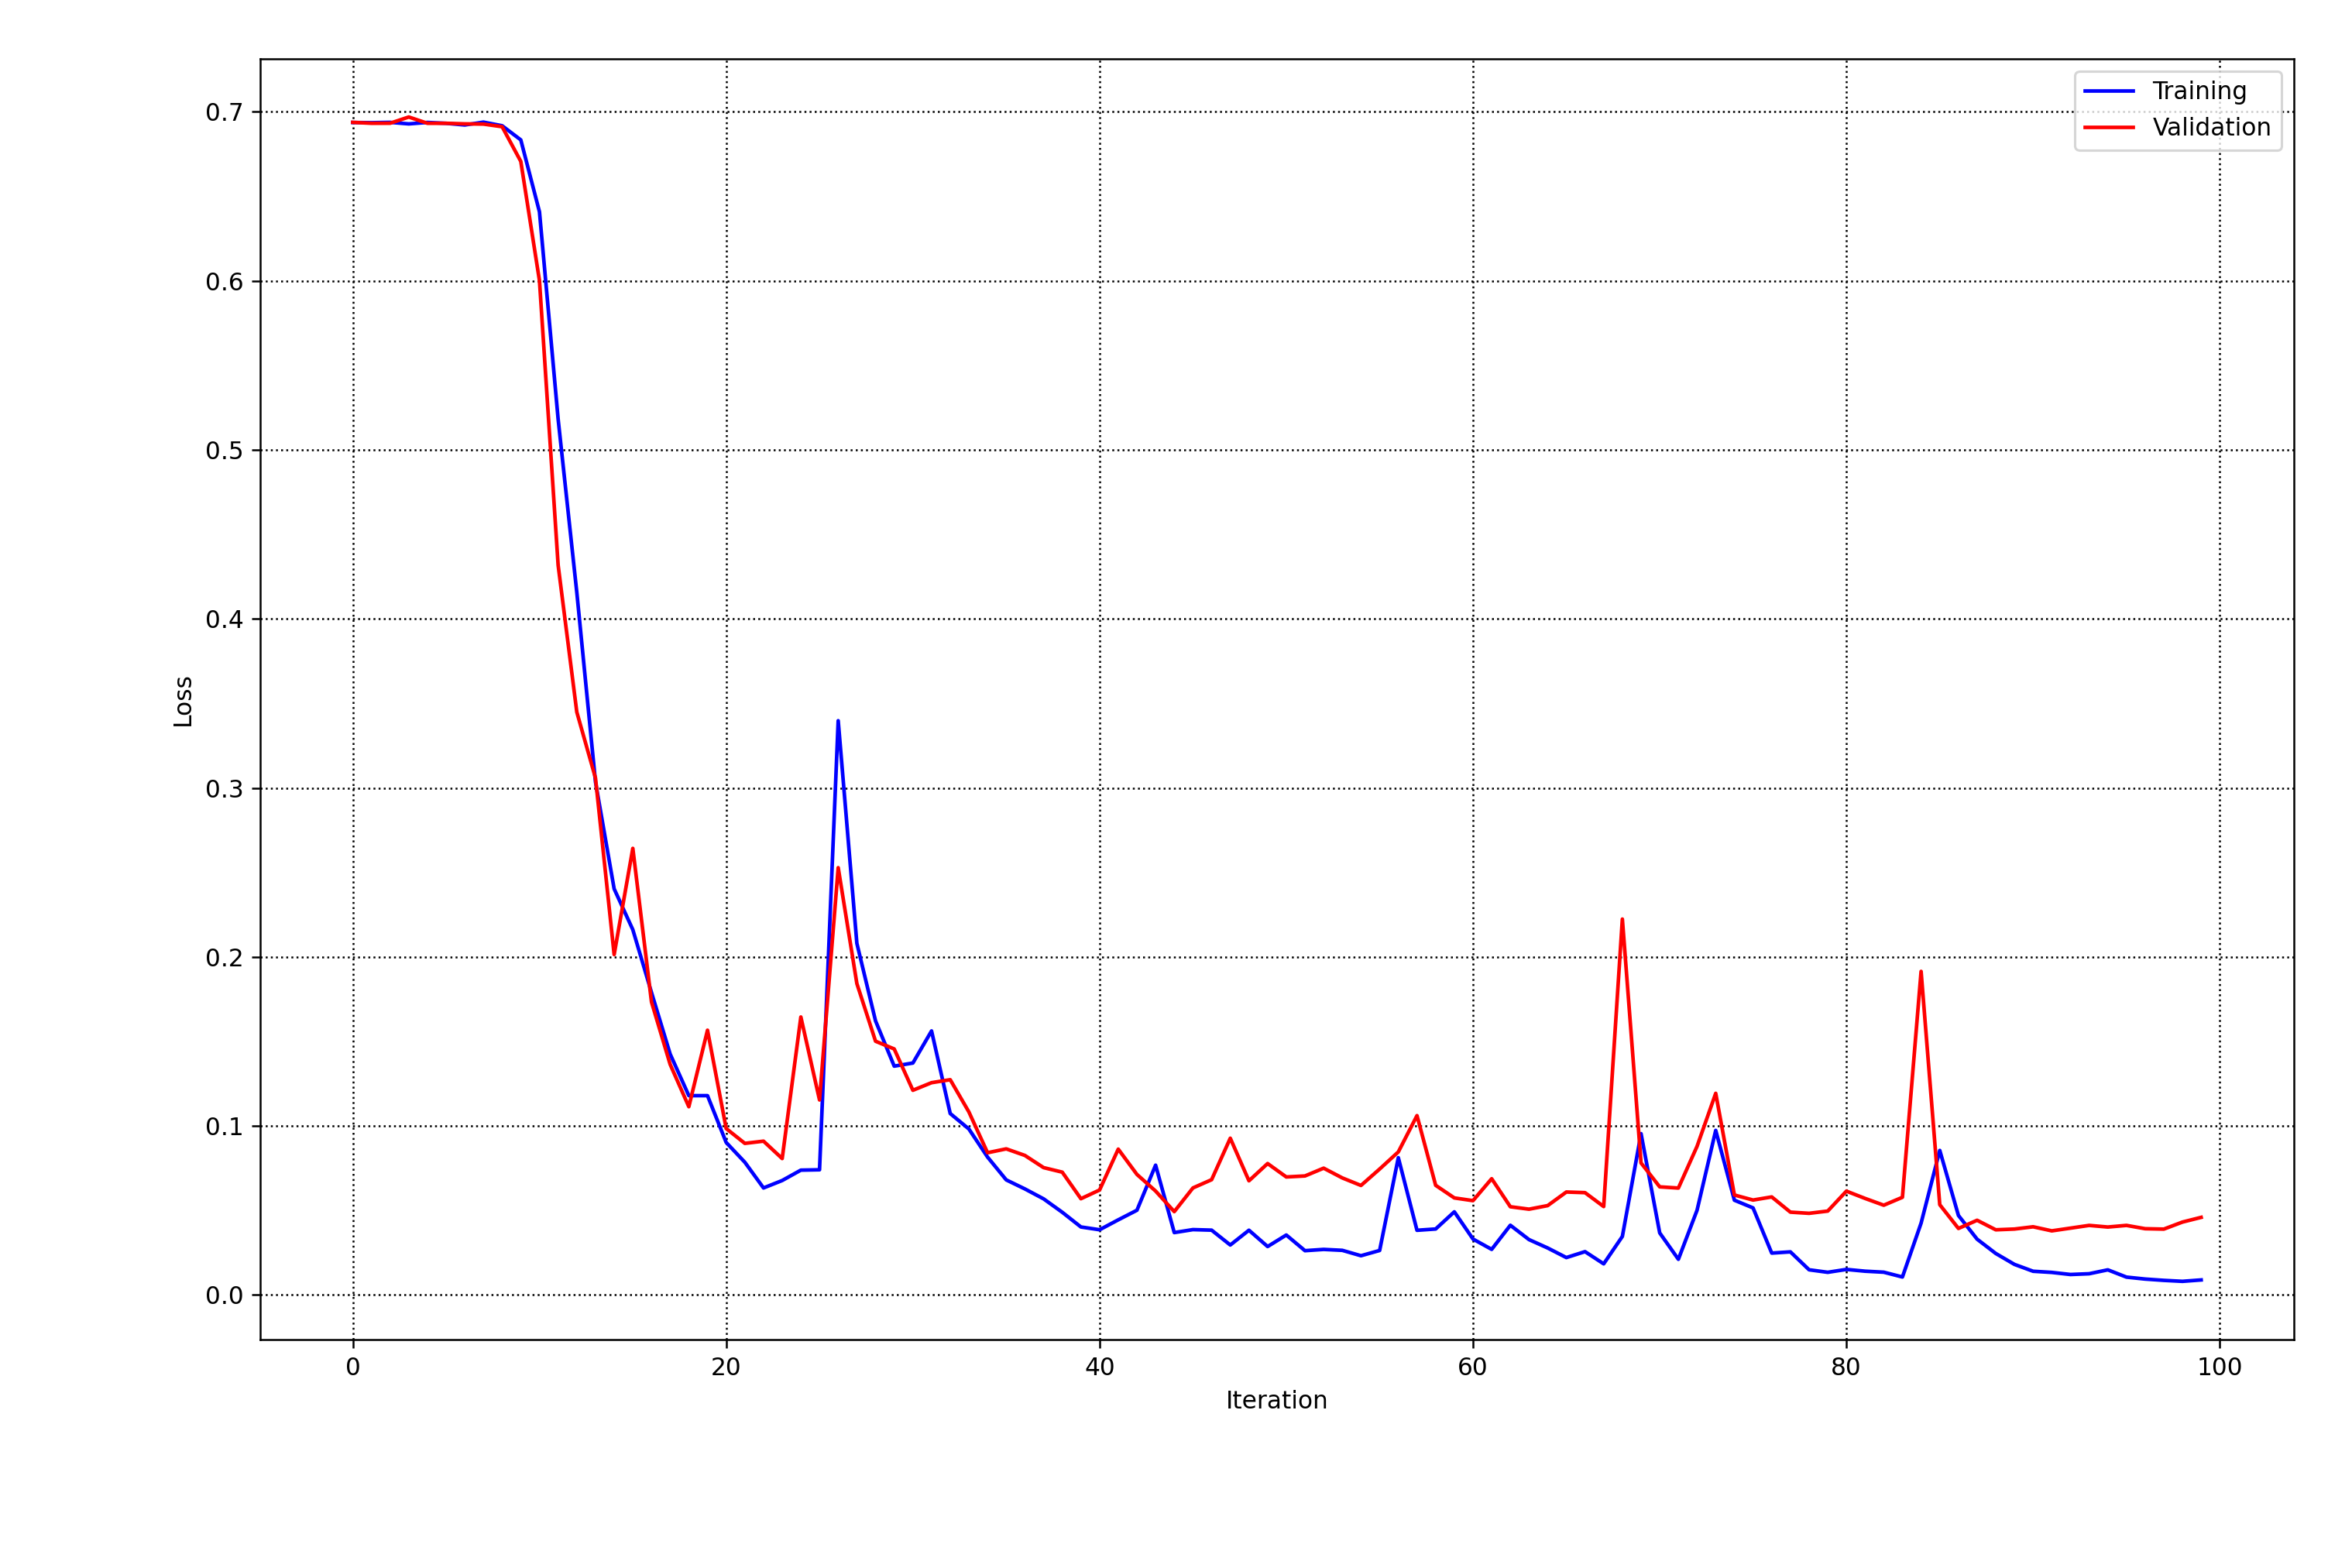

In [126]:
utils.plot_loss(results['long-distance-30']['lstm-pool'].history['loss'],
                results['long-distance-30']['lstm-pool'].history['val_loss'],
                save=True, imgname='loss_lt30_xor_lstmpool')

<IPython.core.display.Javascript object>


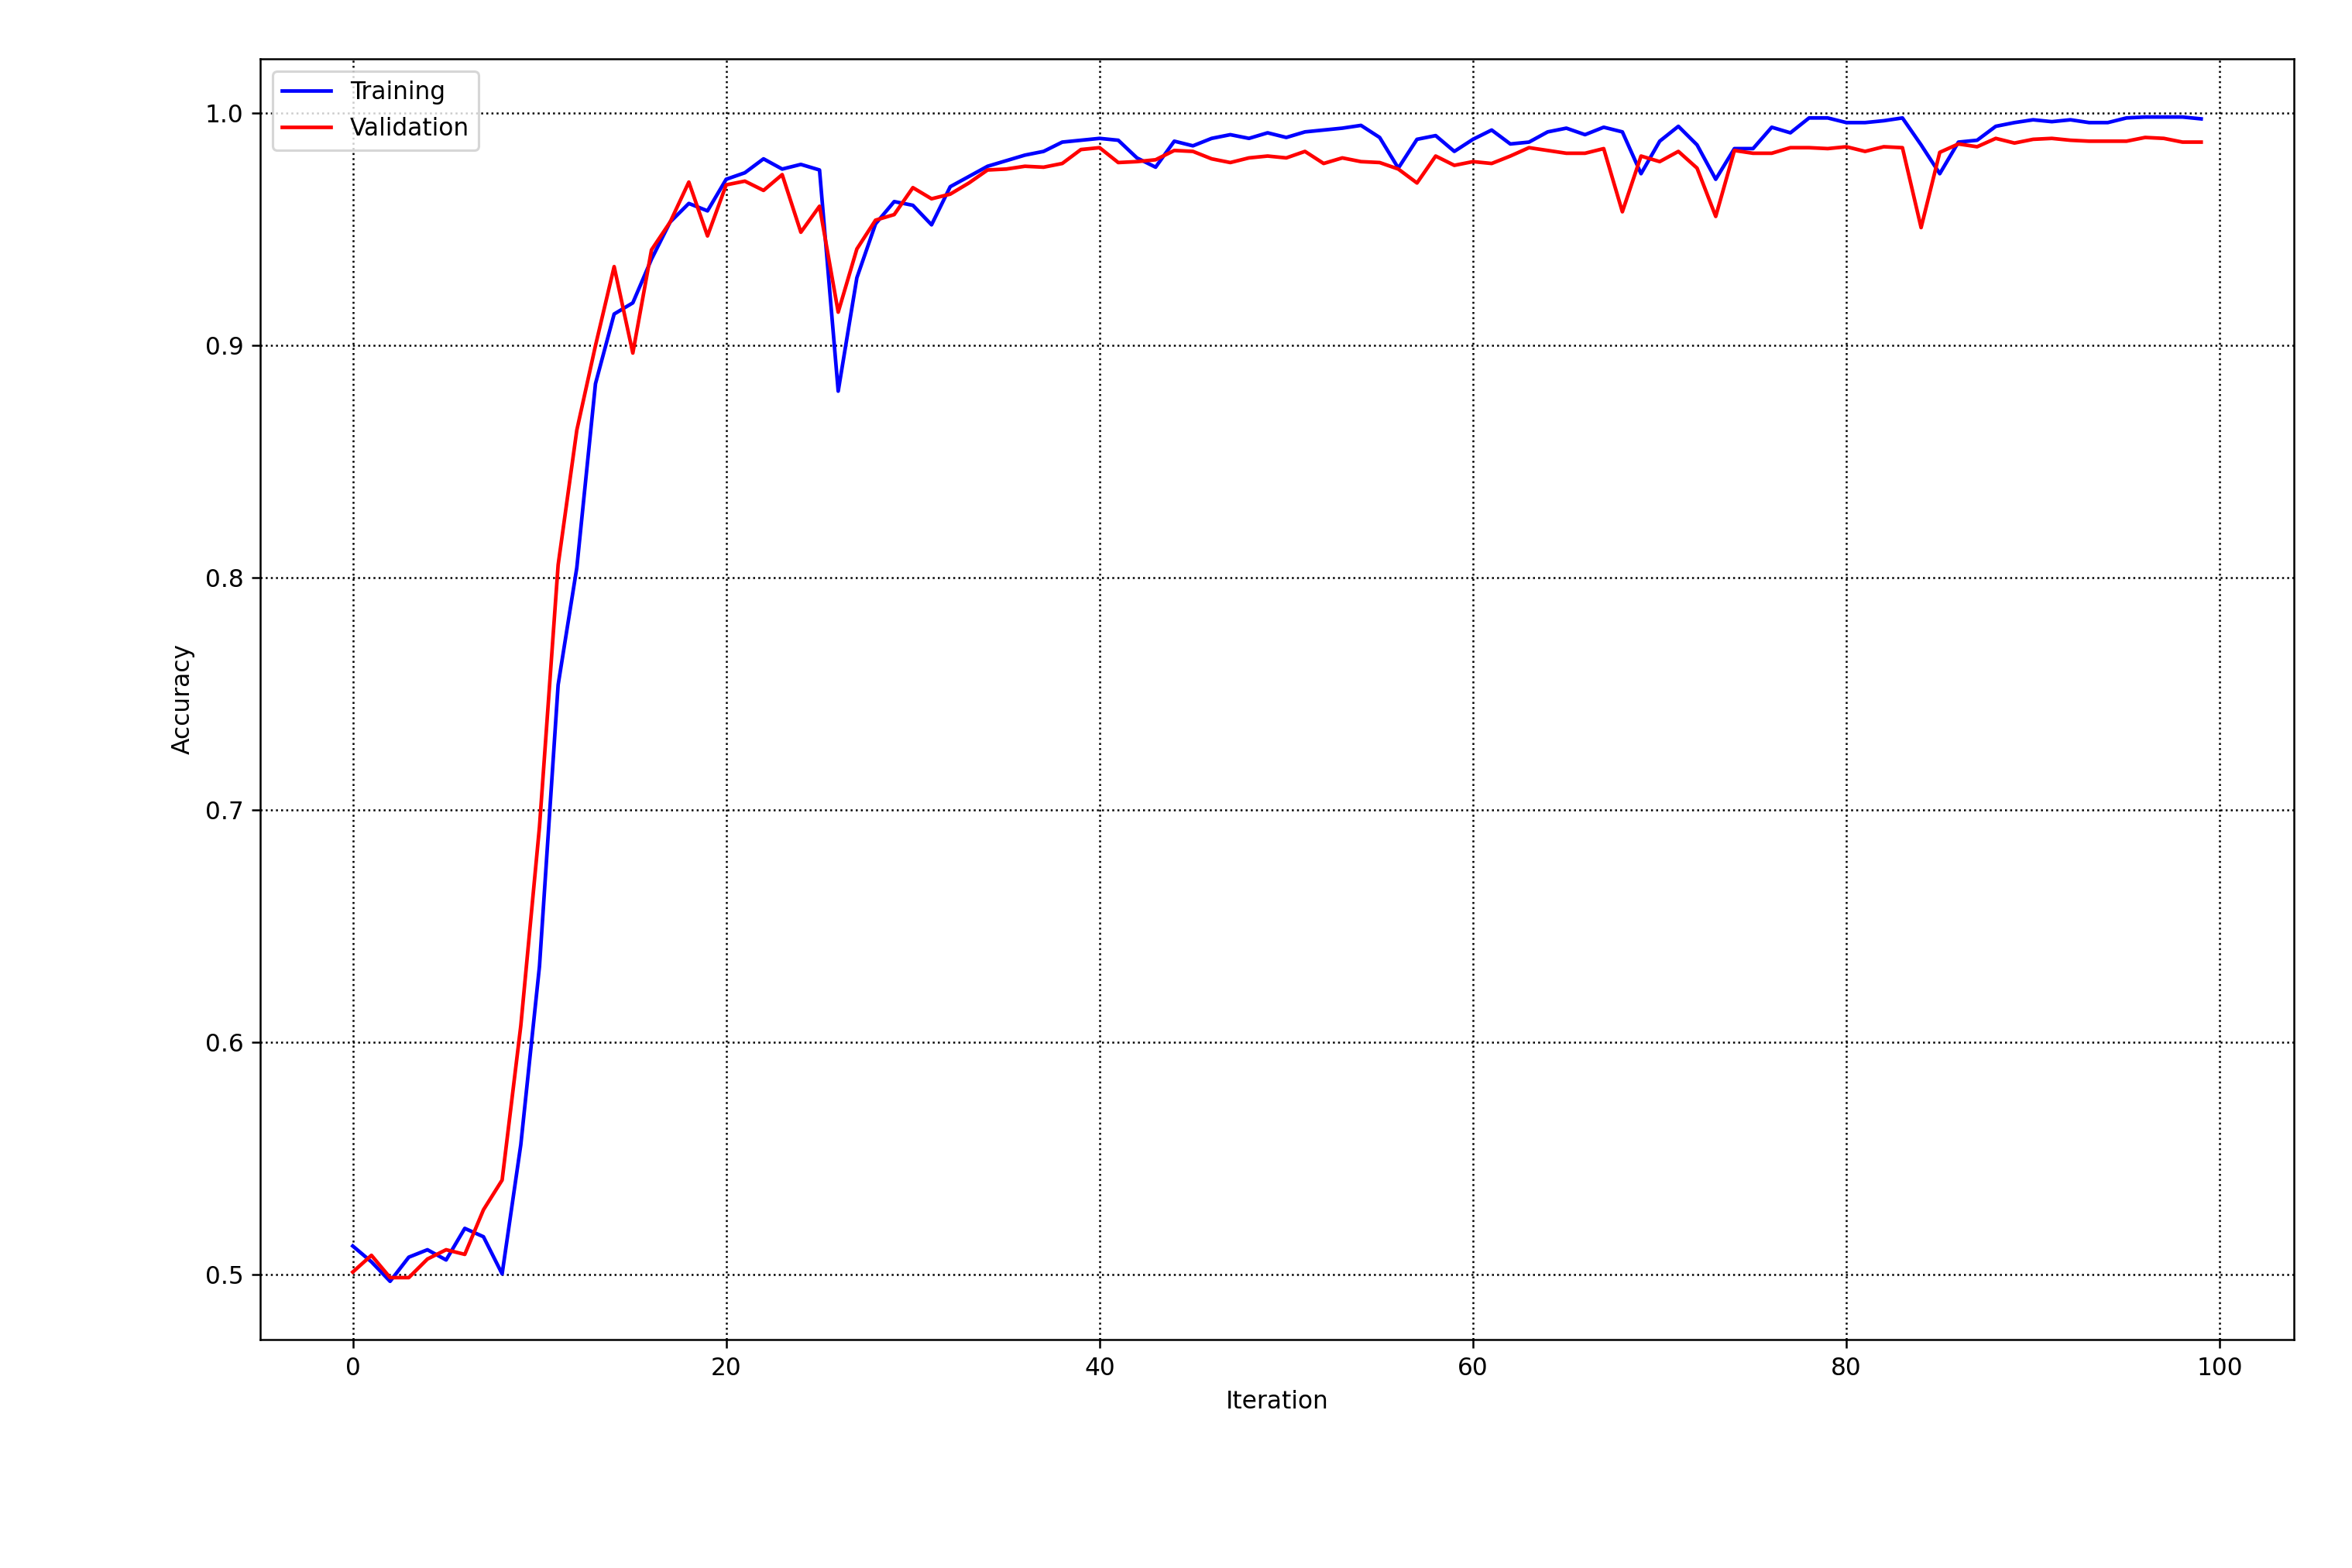

In [127]:
utils.plot_accuracy(results['long-distance-30']['lstm-pool'].history['accuracy'],
                    results['long-distance-30']['lstm-pool'].history['val_accuracy'], 
                    save=True, imgname='accuracy_lt30_xor_lstmpool')

### GRU

In [133]:
inputs = Input(shape=(T, D))

x = GRU(20)(inputs)

x = Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [134]:
results['long-distance-30']['gru'] = model.fit(X, Y, epochs=100, validation_split=0.5, verbose=0)

<IPython.core.display.Javascript object>


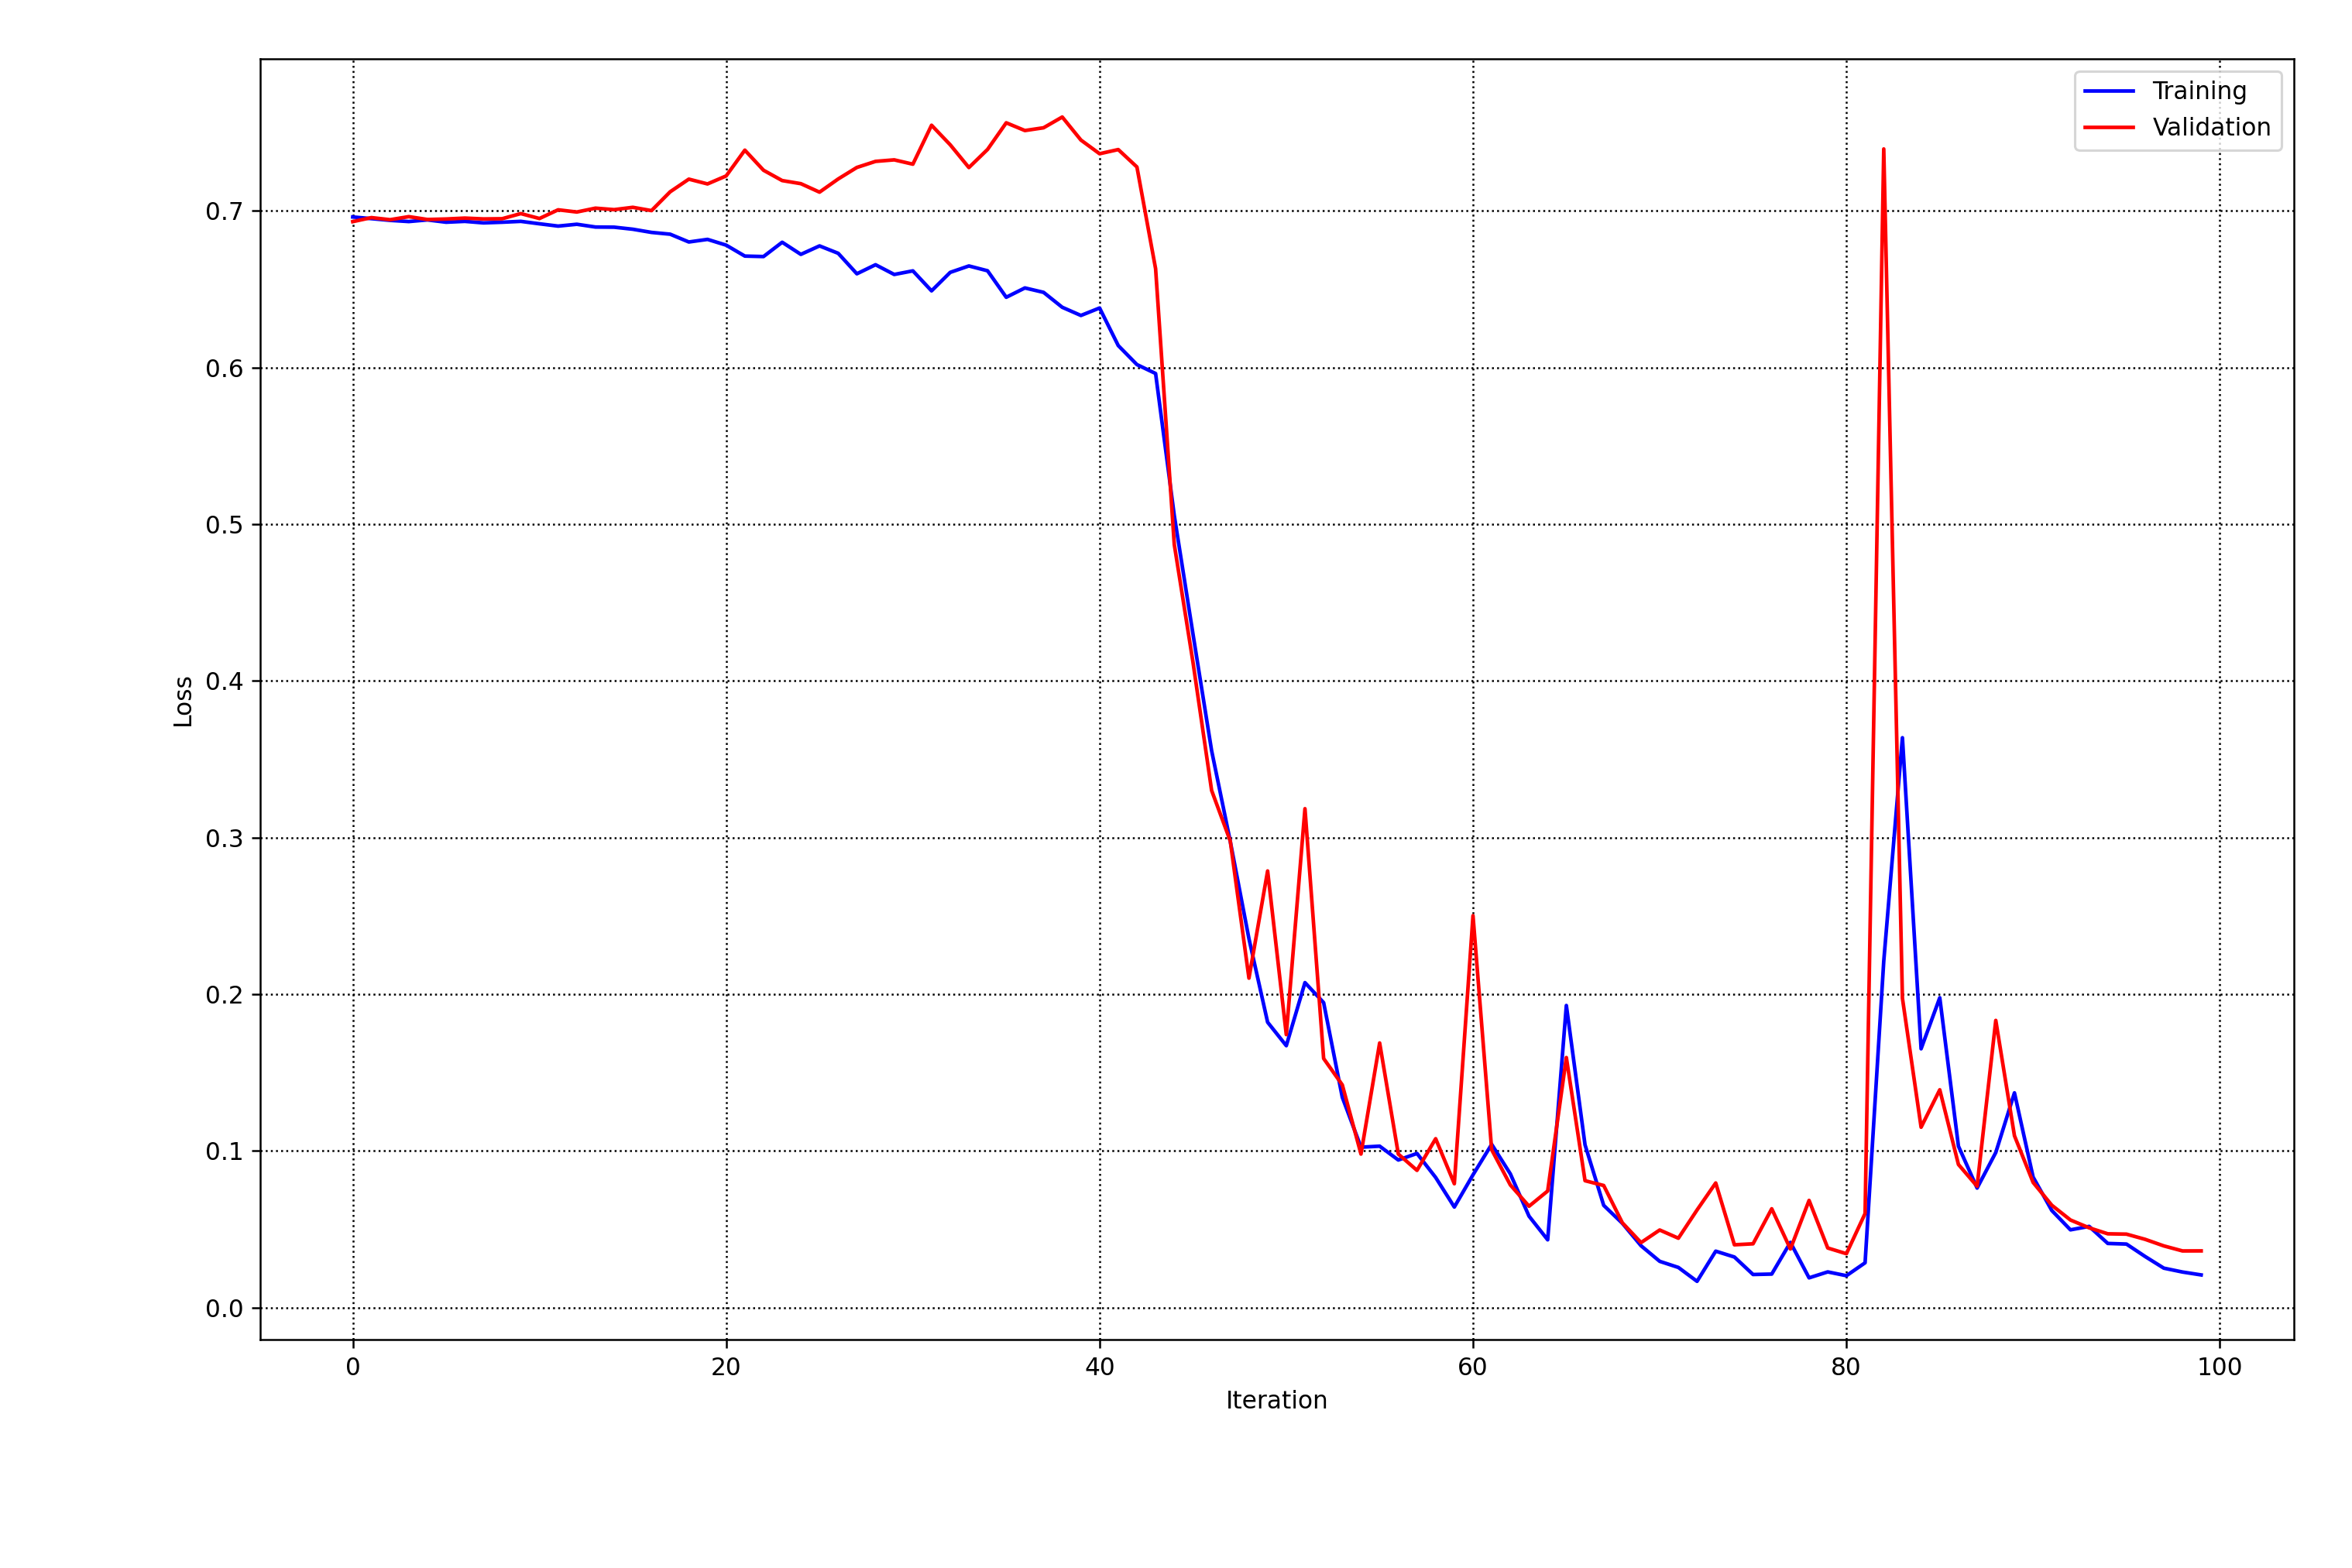

In [135]:
utils.plot_loss(results['long-distance-30']['gru'].history['loss'],
                results['long-distance-30']['gru'].history['val_loss'],
                save=True, imgname='loss_lt30_xor_gru')

<IPython.core.display.Javascript object>


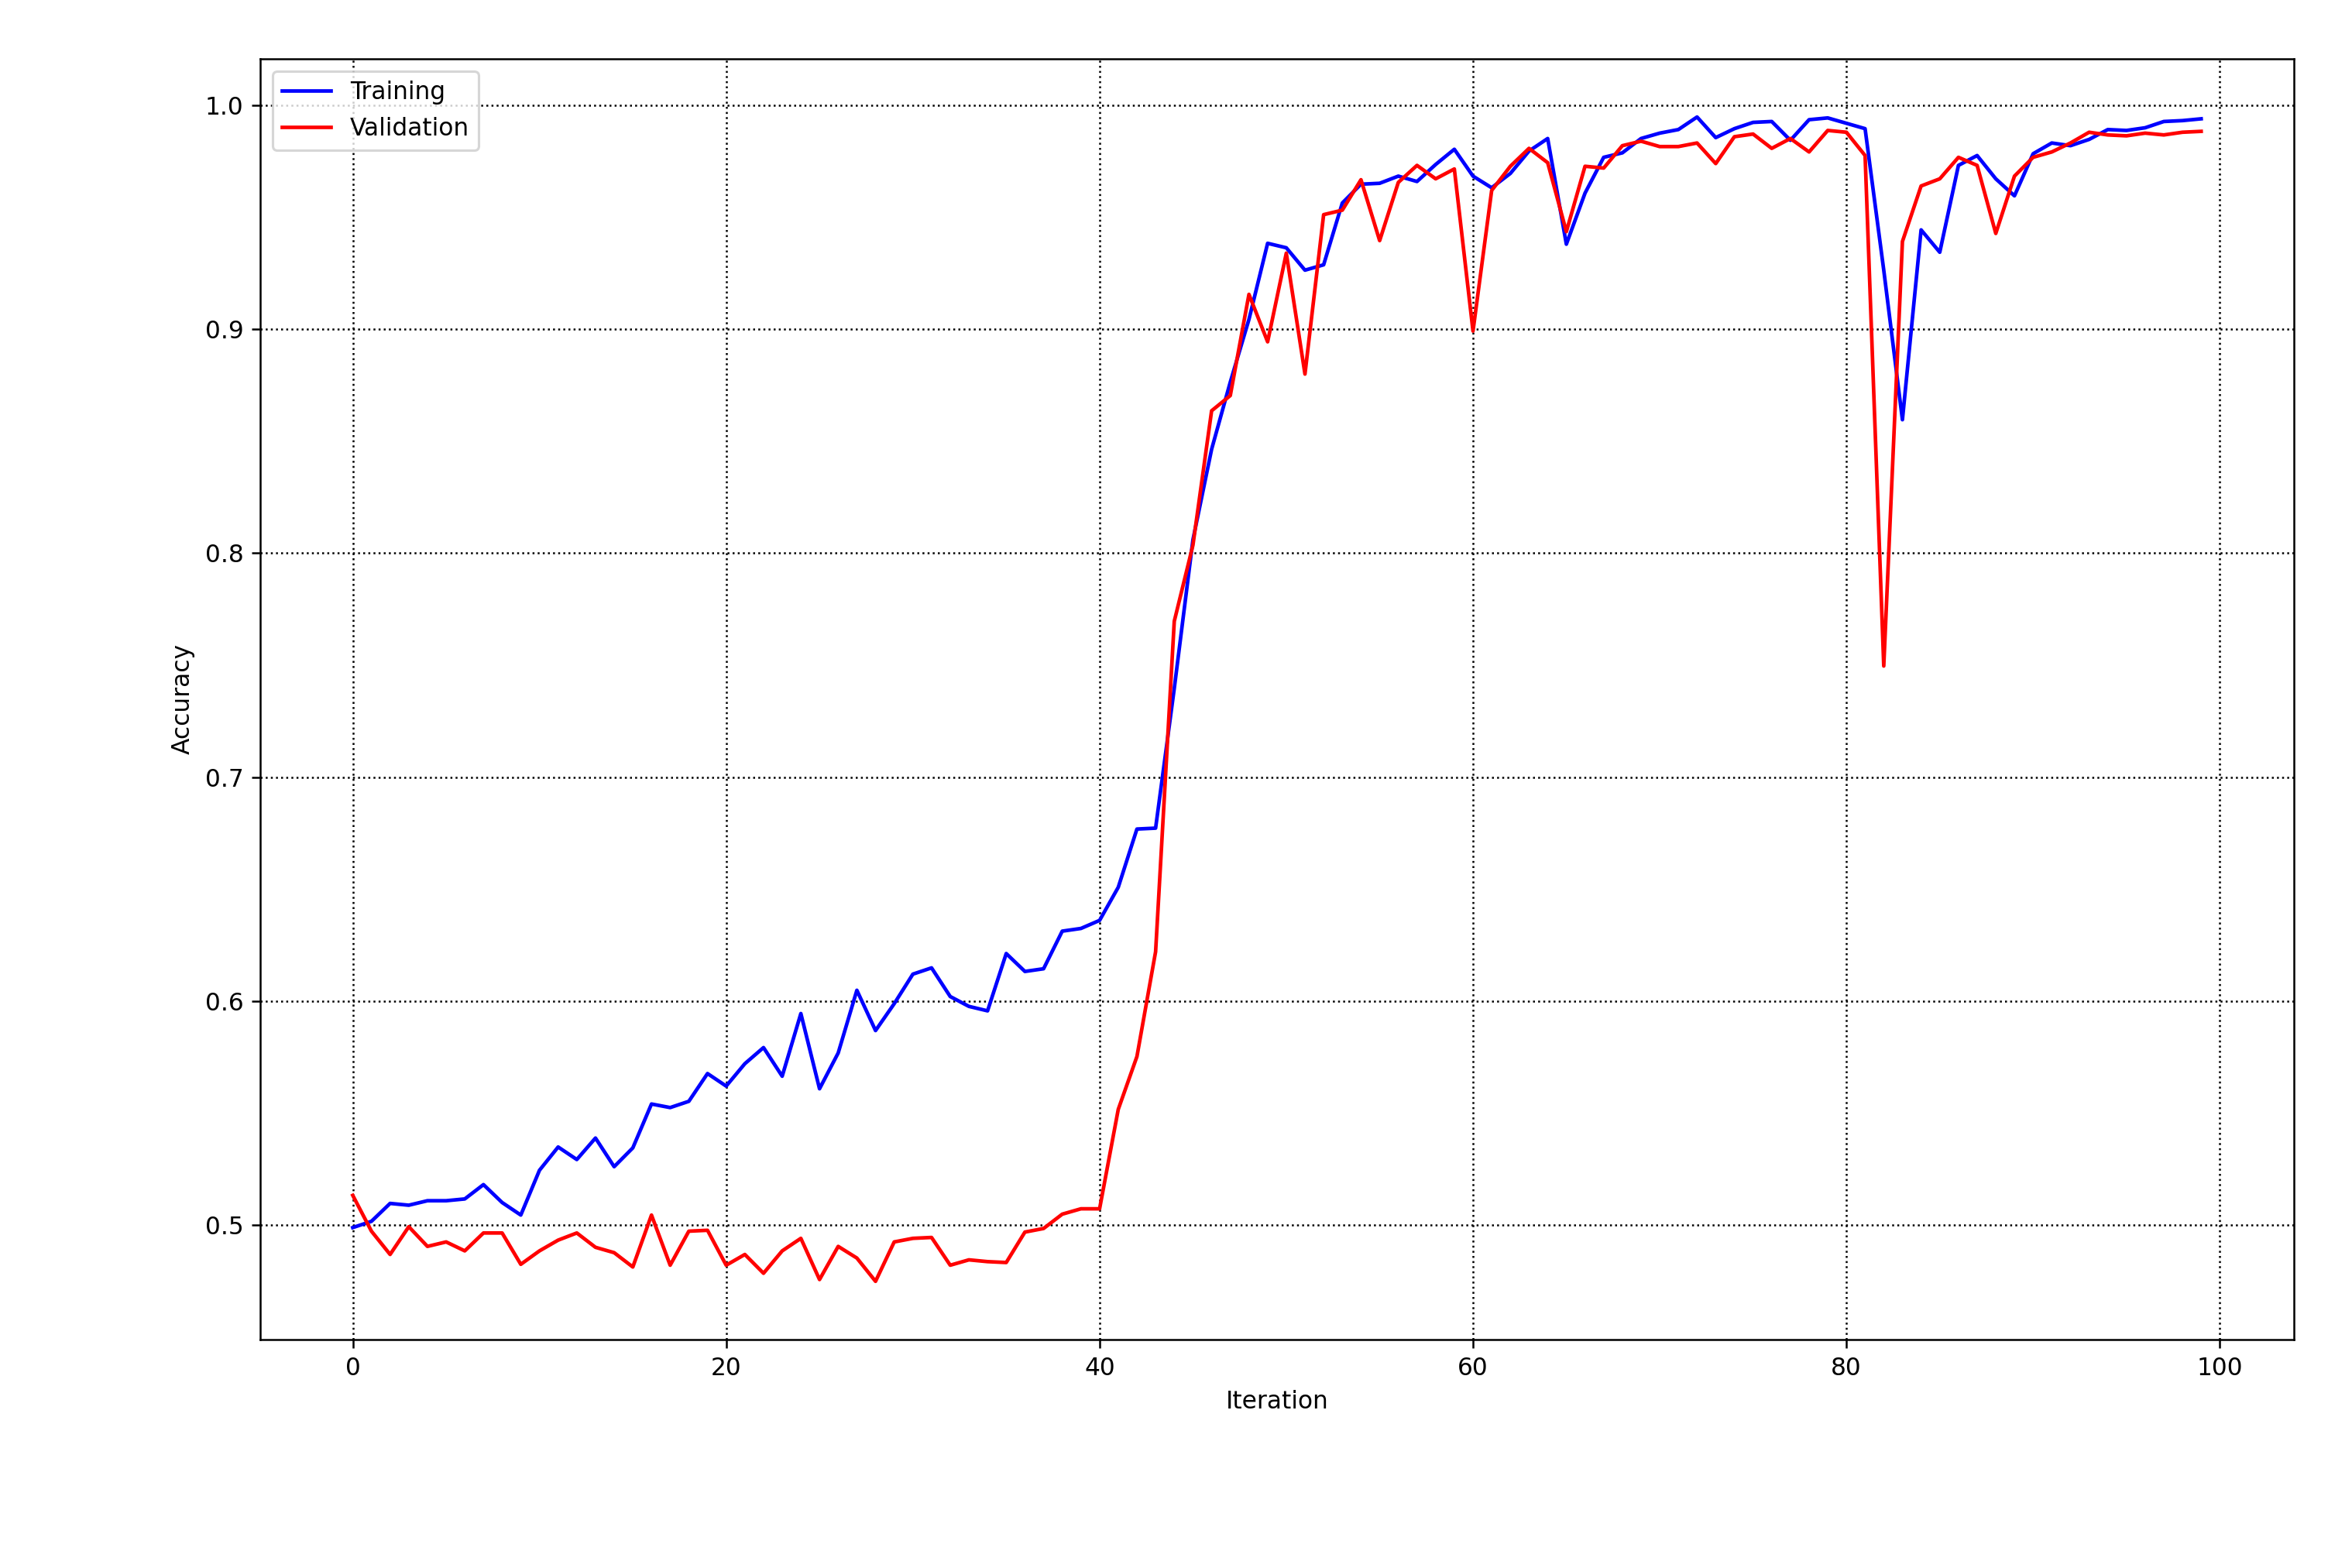

In [136]:
utils.plot_accuracy(results['long-distance-30']['gru'].history['accuracy'],
                    results['long-distance-30']['gru'].history['val_accuracy'], 
                    save=True, imgname='accuracy_lt30_xor_gru')